# Titanic

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import os
import sys
import time
import multiprocessing as mp
from functools import partial
import pickle
import pixiedust
import PIL as pil
from matplotlib import pyplot as plt
import seaborn as sns
from collections import OrderedDict as ODict
import numpy as np
import pandas as pd

# KNN-Impute
import tensorflow as tf
from fancyimpute import KNN

InteractiveShell.ast_node_interactivity = 'all'

# %pixie_debugger
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
sns.set(style='white', context='notebook', palette='tab10')
%config IPCompleter.greedy = True
%config IPCompleter.use_jedi = True

Pixiedust database opened successfully


Using TensorFlow backend.


## Import and Check data

In [2]:
datadir = os.getcwd() + '/../data'
filenames = ['train.csv', 'test.csv']
datadict = ODict()
for files in filenames:
    try:
        with open(datadir + '/' + files, mode='r') as csvfile:
            datadict[files] = pd.read_csv(csvfile, header=0, encoding='ascii')
            csvfile.close()
        print('found file: {}'.format(files))
    except FileNotFoundError:
        print('skipping file ./{}'.format(files))

datadict.keys(), filenames

found file: train.csv
found file: test.csv


(odict_keys(['train.csv', 'test.csv']), ['train.csv', 'test.csv'])

In [3]:
# %%
# Print out data, for quick look.

traindata = datadict[filenames[0]]
testdata = datadict[filenames[-1]]

print(traindata.shape[0],"Rows")

traindata.describe()

891 Rows


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
testdata.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## Exploratory data analysis

In [5]:
train_nulls = (traindata.isnull().sum() / len(traindata)) * 100
train_nulls = train_nulls.drop(train_nulls[train_nulls == 0].index)
test_nulls = (testdata.isnull().sum() / len(testdata)) * 100
test_nulls = test_nulls.drop(test_nulls[test_nulls == 0].index)
train_missing = pd.DataFrame({'Training NaNs' :train_nulls})
train_missing.index.name = 'Metric'
test_missing = (pd.DataFrame({'Test NaNs' :test_nulls}))
test_missing.index.name = 'Metric'
all_missing = pd.merge(train_missing, test_missing, on='Metric', how='outer')
all_missing.head()

,Training NaNs,Test NaNs
Metric,,
Age,19.865320,20.574163
Cabin,77.104377,78.229665
Embarked,0.224467,NaN
Fare,NaN,0.239234


In [6]:
# Fill empty's with NaNs
traindata = traindata.fillna(np.nan)
testdata = testdata.fillna(np.nan)

### Exploring our Variables

    * PassengerId -> Ignore
    * Pclass -> Categorical -> Survival Probability
    * Name -> Categorical with Title (after Extraction) -> Survival Probability
    * Sex -> Categorical -> Survival Probability
    * Age -> Continous / Categorical (Binned) -> Survival Probability
    * SibSP -> Categorical -> Survival Probability
    * Parch -> Categorical -> Survival Probability
    * Ticket -> ? -> Needs Features
    * Fare -> Continous / Categorical (Binned) -> Survival Probability
    * Cabin -> ? (Deck | Deck Position | ?) -> Needs Features
    * Embarked -> Categorical -> Survival Probability

,Survived
Pclass,
3,491
1,216
2,184


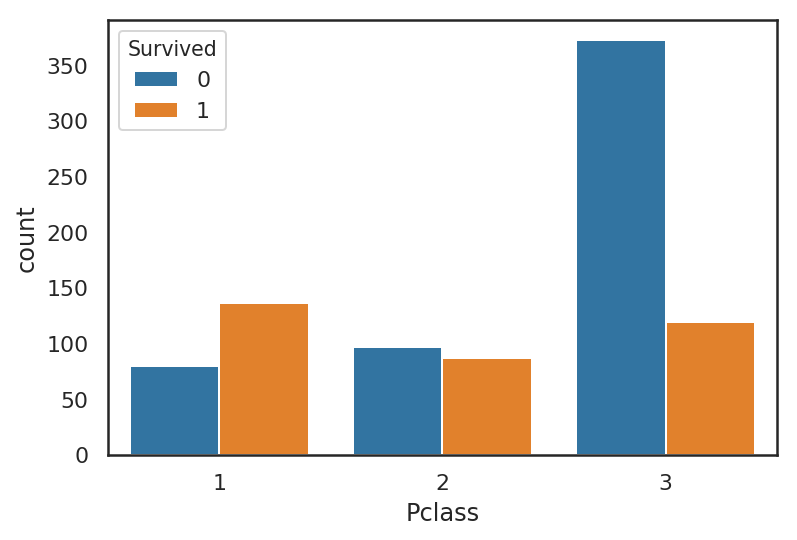

In [7]:
# Pclass
ax_pc = sns.countplot(x='Pclass',
                   hue="Survived",
                   data=traindata)

traindata[['Pclass',
           'Survived']].groupby('Pclass').count().sort_values(by='Survived',
                                                                    ascending=False)

Text(0, 0.5, 'Survival Probability')

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


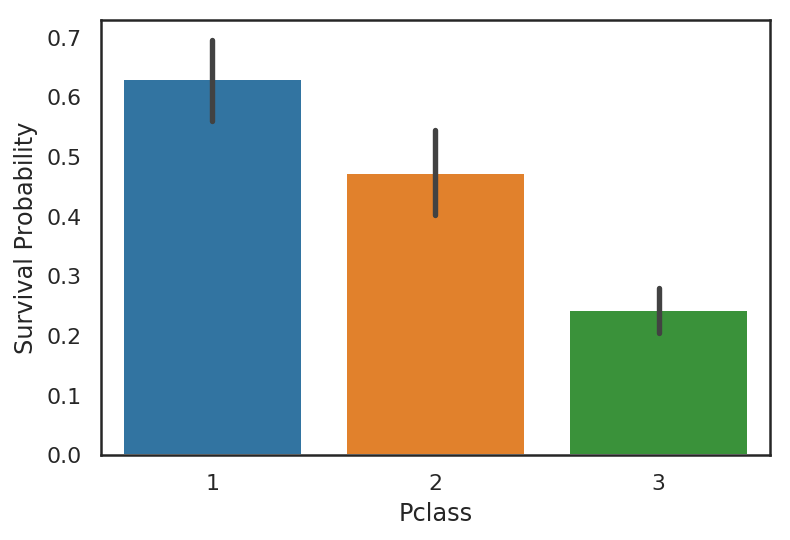

In [8]:
ax_pp = sns.barplot(x='Pclass',
                   y='Survived',
                   data=traindata)

ax_pp.set_ylabel("Survival Probability")

traindata[['Pclass',
           'Survived']].groupby(['Pclass']).mean().sort_values(by='Survived',
                                                             ascending=False)

In [9]:
# Names

Prefixes = ['Mr.','Mrs.',
            'Master.','Miss.',
            'Don.','Dr.','Rev.',
            'Col.','Major.',
            'Ms.','Mme.','Lady.',
            'Sir.','Mlle.','Countess.',
            'Capt.','Jonkheer.']

def apply_prefix(s) -> str:
    
    Prefixes = ['Mr.','Mrs.','Master.','Miss.',
                'Don.','Dr.','Rev.','Col.',
                'Major.','Ms.','Mme.','Lady.',
                'Sir.','Mlle.','Countess.','Capt.','Jonkheer.']
    
    for _pf_ in Prefixes:
        if _pf_ in s:
            return _pf_
    return None

Pf_data = traindata.loc[:,('Name','Survived')]
Pf_data['Prefix'] = traindata.copy().loc[:,'Name'].astype(str).apply(apply_prefix) 

Text(0, 0.5, 'Survival Probability by Title')

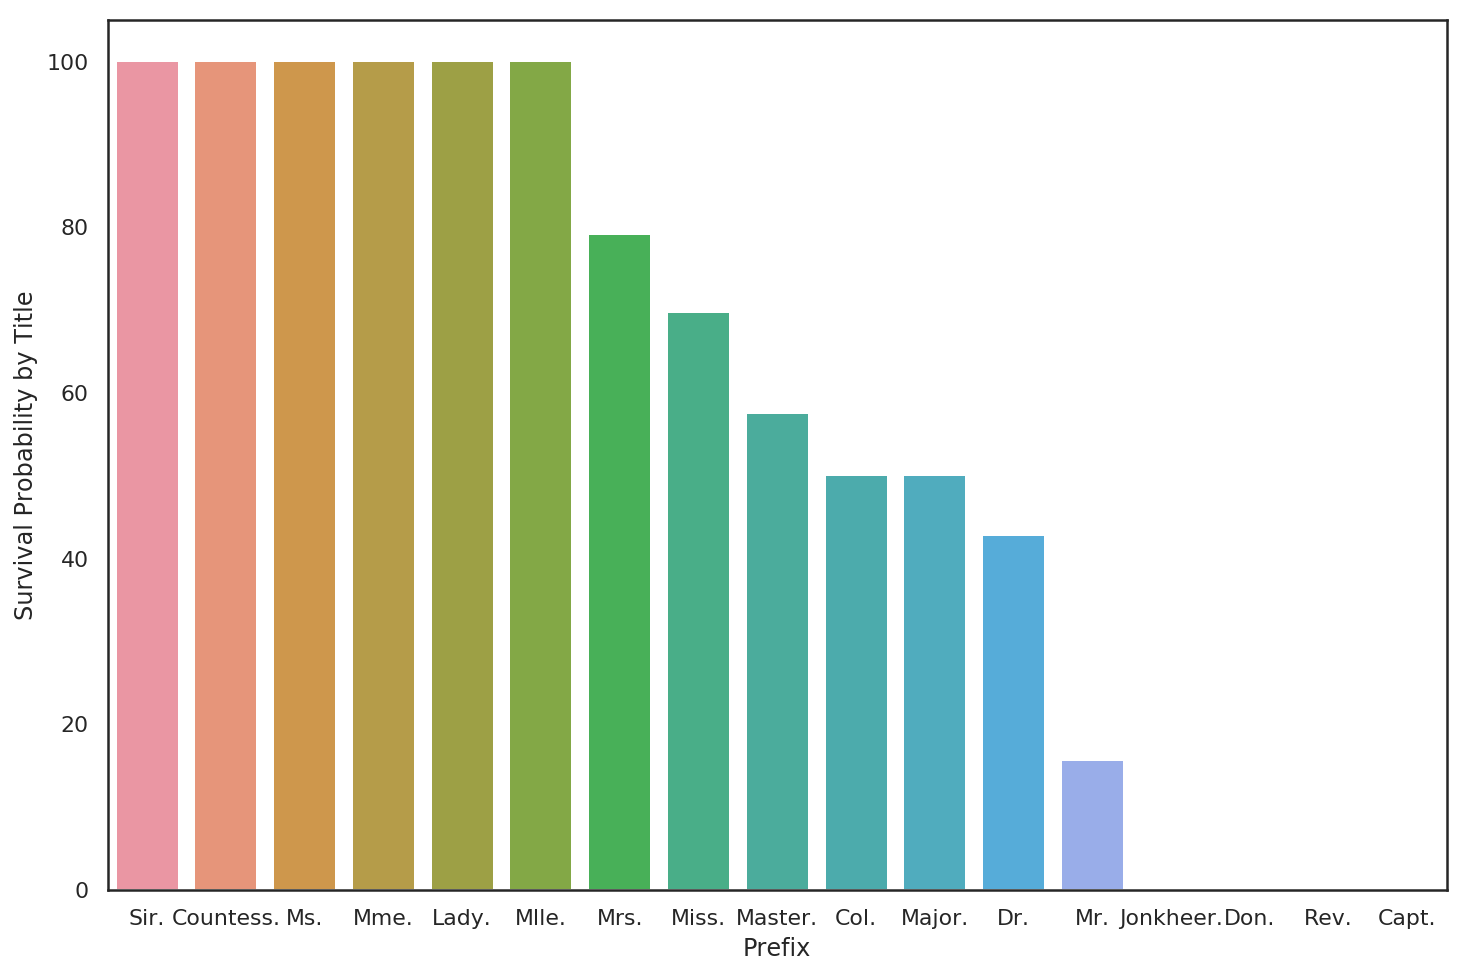

In [10]:
P = Pf_data[['Prefix',
             'Survived']].groupby('Prefix').mean().sort_values(by='Survived',
                                                               ascending=False) * 100
C = Pf_data[['Prefix',
             'Survived']].groupby('Prefix').count().sort_values(by='Survived',
                                                                ascending=False)
byNames = pd.merge(P,C,how='outer',on='Prefix')
byNames.columns = ['Survived(%)','Survived(N)']
byNames.index.name='Prefix'

fig = plt.figure(figsize=(12,8))

ax_np = sns.barplot(x=byNames.index,y=byNames['Survived(%)'])
ax_np.set_ylabel('Survival Probability by Title')

Text(0, 0.5, 'Survival Probability')

,Survived
Sex,
female,0.742038
male,0.188908


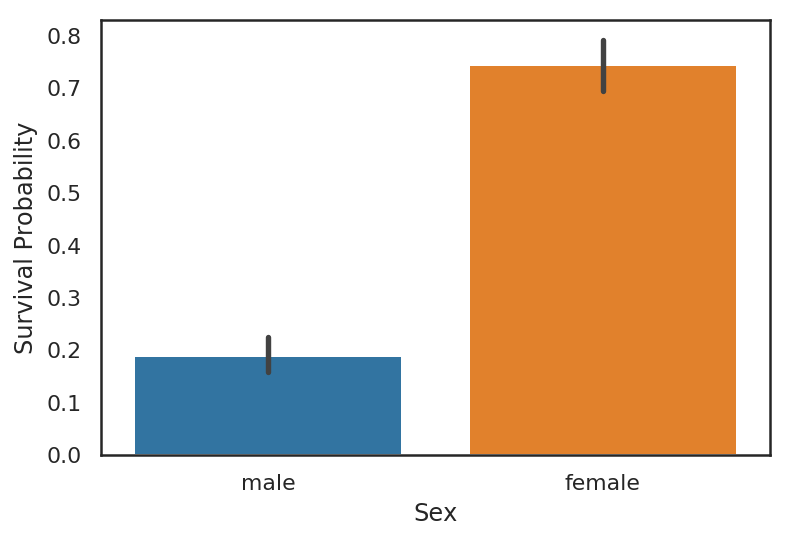

In [11]:
# by Gender

ax_gn = sns.barplot(x='Sex',y='Survived',data=traindata)
ax_gn.set_ylabel('Survival Probability')

traindata[['Sex','Survived']].groupby(['Sex']).mean()

/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'Survivors v/s Non Survivors by Age')

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Probability')

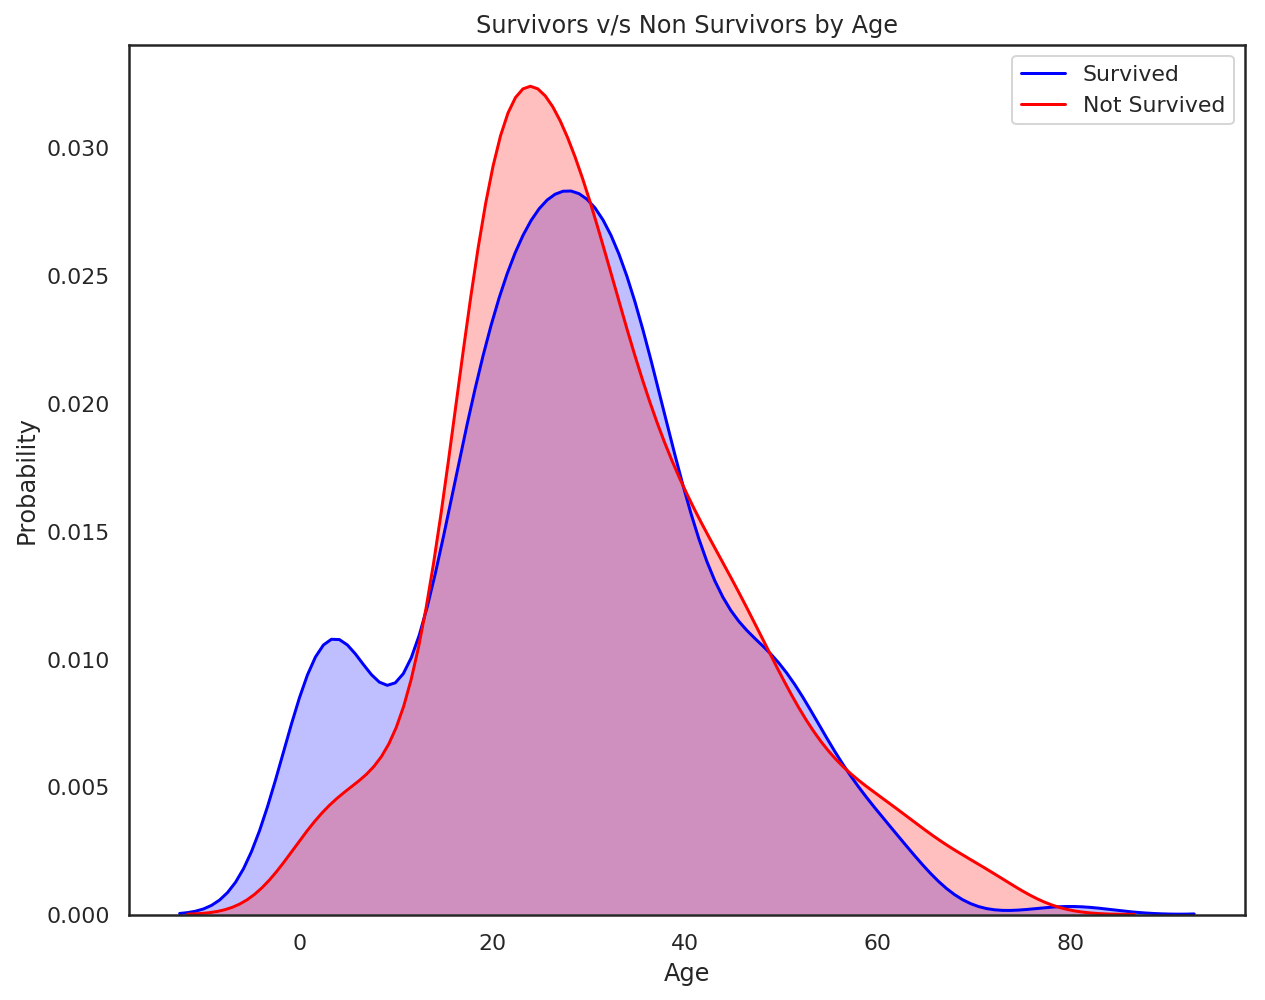

In [12]:
# by Age - Continuous KDE

fig = plt.figure(figsize=(10,8))

ax = sns.kdeplot(traindata.loc[(traindata['Survived']==1),('Age')],
                 color='b',
                 shade=True,
                 label='Survived')

ax = sns.kdeplot(traindata.loc[(traindata['Survived']==0),('Age')],
                 color='r',
                 shade=True,
                 label='Not Survived')

plt.title('Survivors v/s Non Survivors by Age')
plt.xlabel('Age')
plt.ylabel('Probability')

/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Text(0, 0.5, 'Survival Probability by Age Group')

,Survived
Age_Binned,
0-10,0.593750
10-20,0.382609
20-30,0.365217
30-40,0.445161
40-50,0.383721
50-60,0.404762
60-70,0.235294
70-80,0.200000


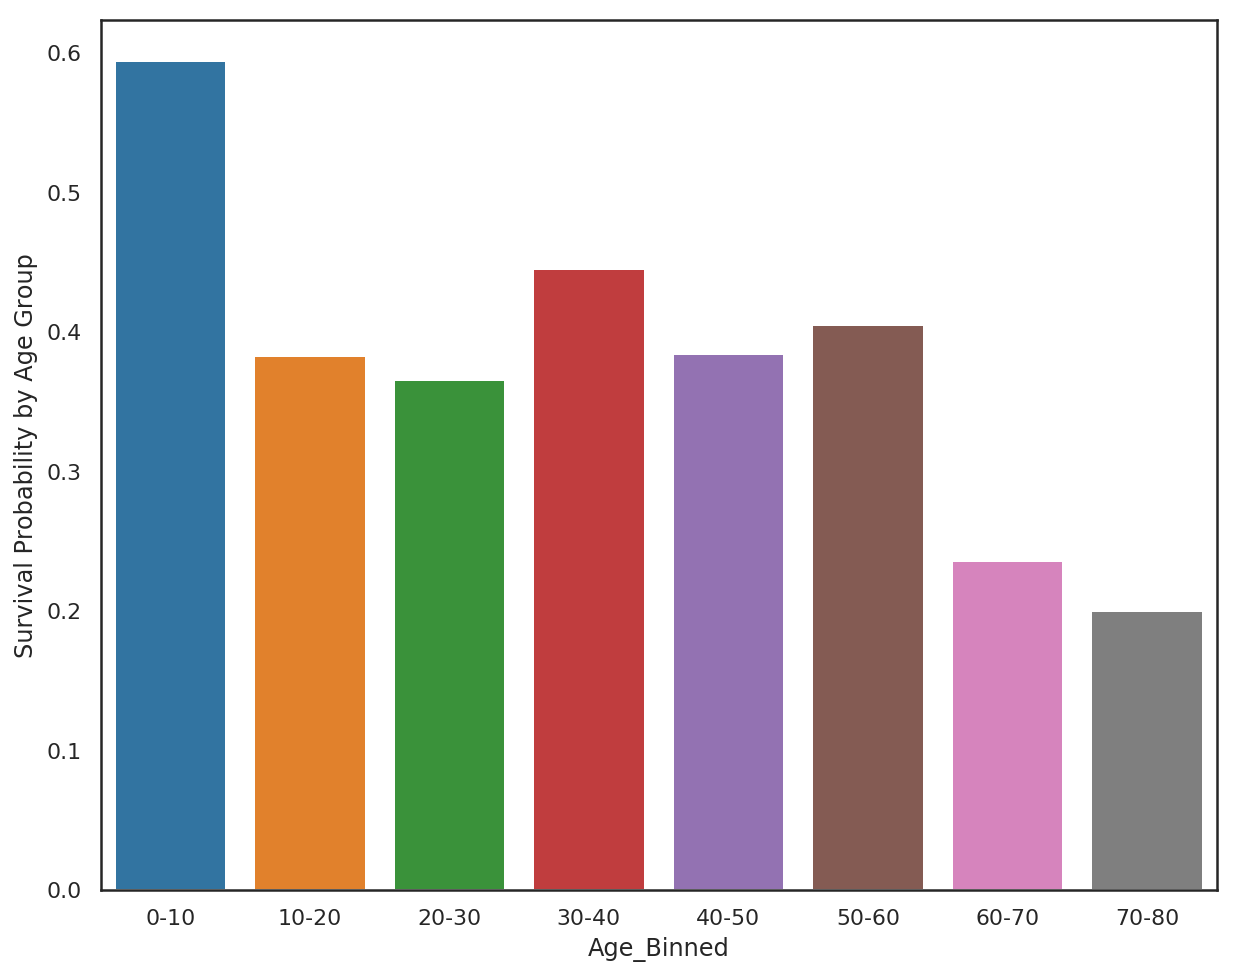

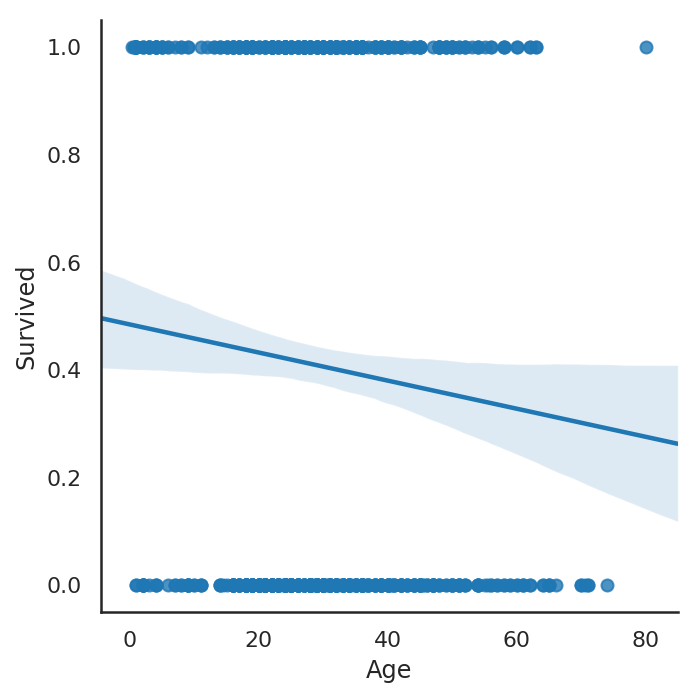

In [13]:
# by Age - Discrete Age Binning

fig = plt.figure(figsize=(10,8))

ageDF = traindata[['Age','Survived']]

maxage, minage = int(ageDF.Age.max()), int(ageDF.Age.min())
agebins = np.arange(minage, maxage+10, 10)
agelabels = [str(agebins[i])+'-'+str(agebins[i+1])
             for i in range(len(agebins)-1)]


ageDF['Age_Binned'] = pd.cut(ageDF.loc[:,('Age')],
                             bins=agebins,
                             labels=agelabels)


Binned_Probs = ageDF[['Age_Binned','Survived']].groupby(['Age_Binned']).mean()

ax_ag = sns.barplot(x=Binned_Probs.index,
                    y='Survived', 
                    data=Binned_Probs)

ax_lmag = sns.lmplot('Age','Survived',data=ageDF)

ax_ag.set_ylabel('Survival Probability by Age Group')

Binned_Probs

Text(0, 0.5, 'Survival Probabibility')

Text(0.5, 0, 'Number of siblings on board')

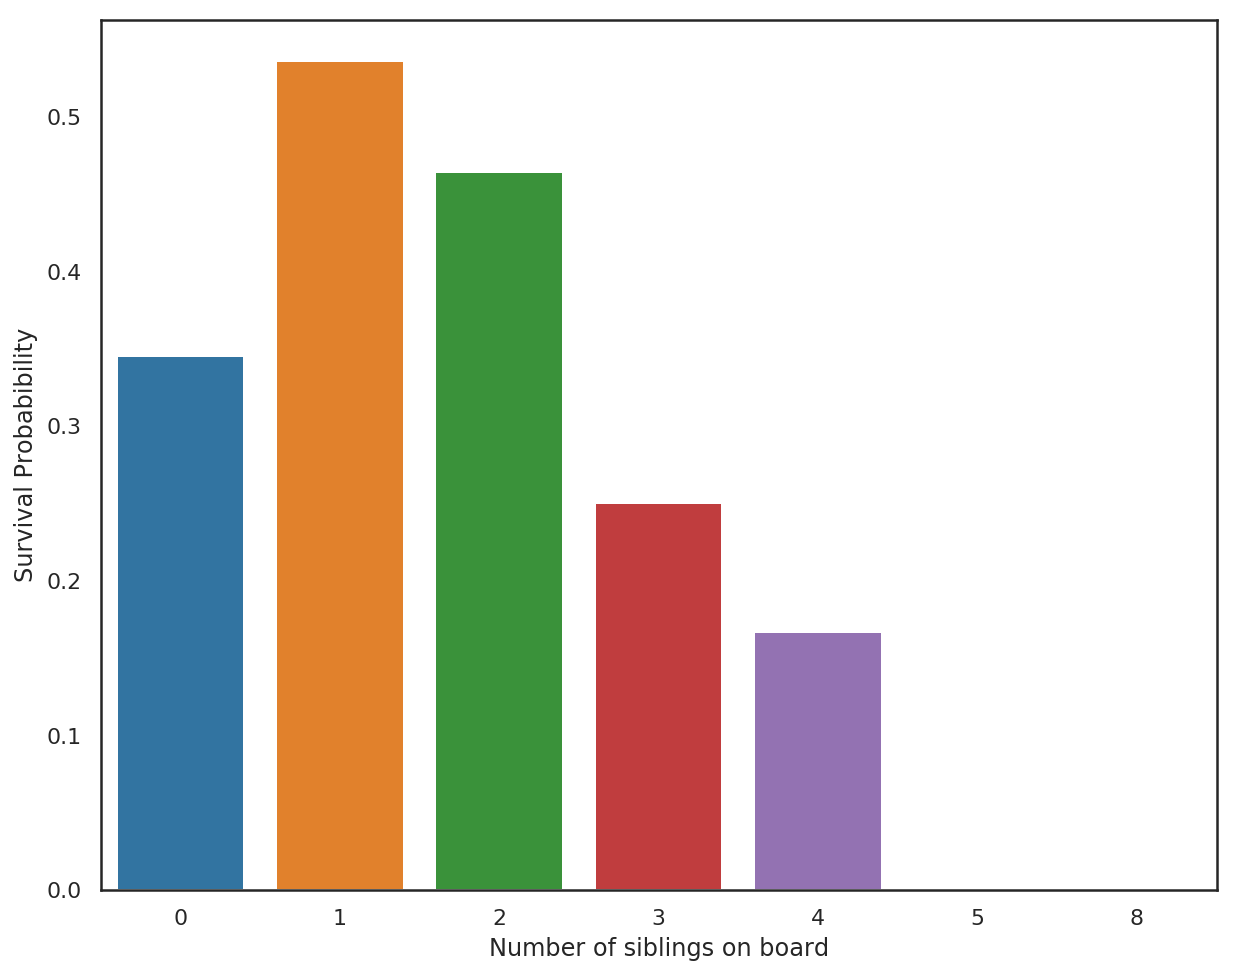

In [14]:
# by siblings on board

fig = plt.figure(figsize=(10,8))

sib_data = traindata[['SibSp', 'Survived']].groupby(['SibSp']).mean()

ax_sb = sns.barplot(x=sib_data.index, y='Survived', data=sib_data)
ax_sb.set_ylabel('Survival Probabibility')
ax_sb.set_xlabel('Number of siblings on board')

Text(0, 0.5, 'Survival Probabibility')

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


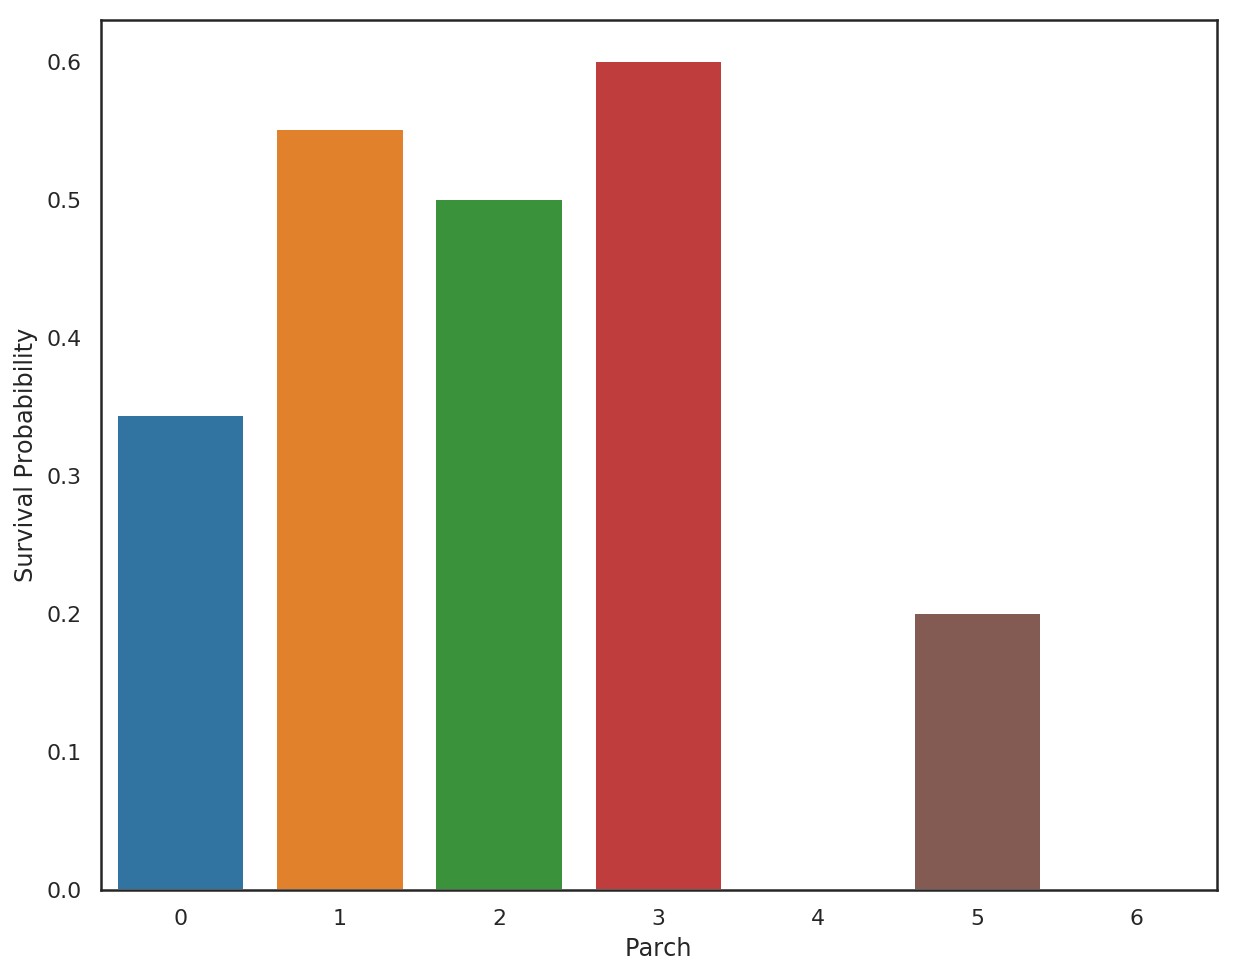

In [15]:
# by parents on board

fig = plt.figure(figsize=(10,8))

Parch_data = traindata[['Parch', 'Survived']].groupby(['Parch']).mean()

ax_sb = sns.barplot(x=Parch_data.index, y='Survived', data=Parch_data)
ax_sb.set_ylabel('Survival Probabibility')

Parch_data

Text(0.5, 1.0, 'Survivors v/s Non Survivors by Fare')

Text(0.5, 0, 'Fare')

Text(0, 0.5, 'Probability')

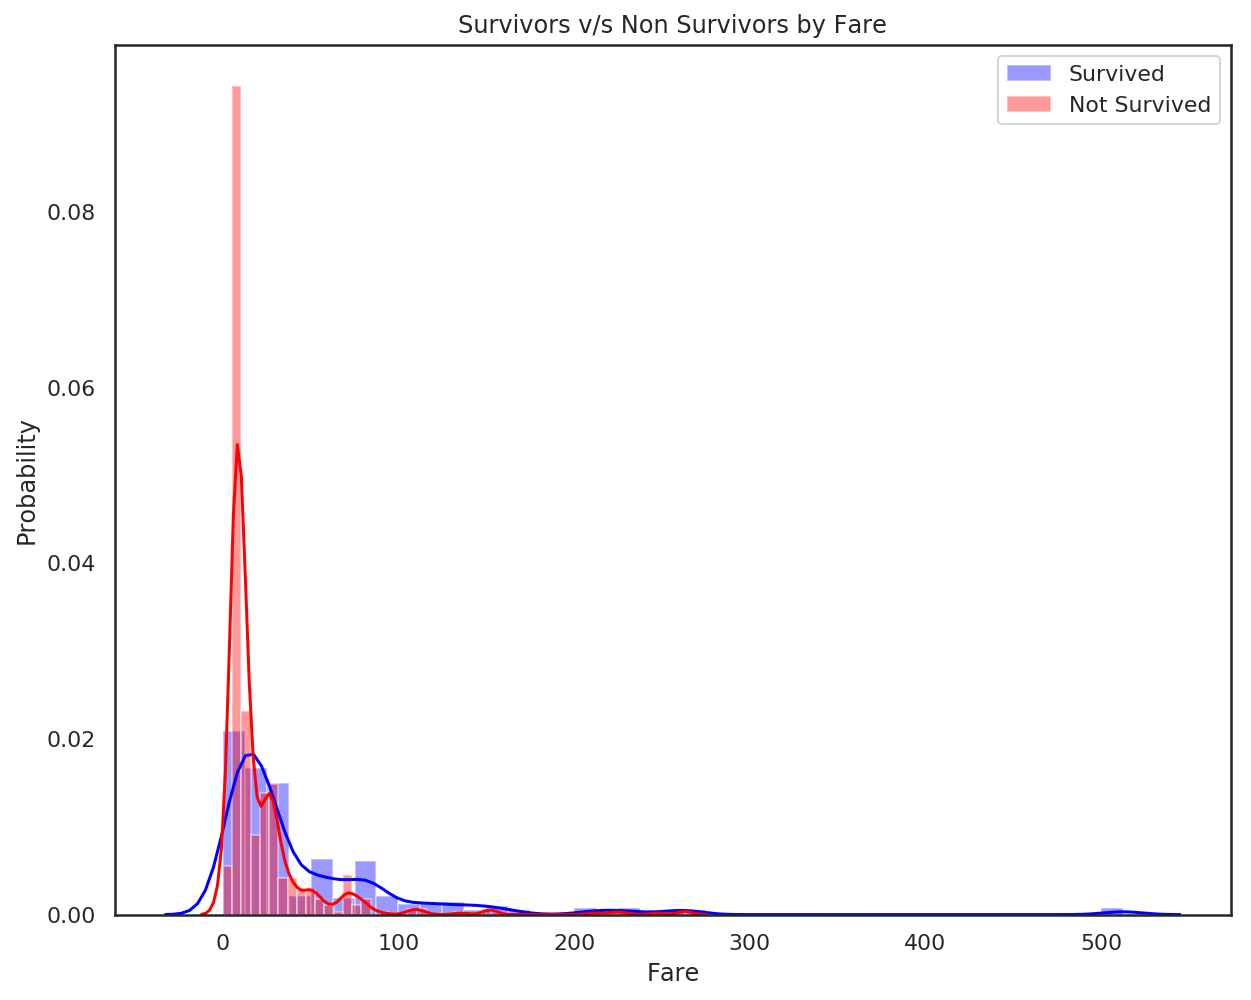

In [16]:
# by fares

fig = plt.figure(figsize=(10,8))

ax = sns.distplot(traindata.loc[(traindata['Survived']==1),('Fare')],
                 color='b',
                 label='Survived')

ax = sns.distplot(traindata.loc[(traindata['Survived']==0),('Fare')],
                 color='r',
                 label='Not Survived')

plt.title('Survivors v/s Non Survivors by Fare')
plt.legend()
plt.xlabel('Fare')
plt.ylabel('Probability')

In [17]:
# Cabin
traindata['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Text(0, 0.5, 'Count')

,Survived
Embarked,
C,168
Q,77
S,644


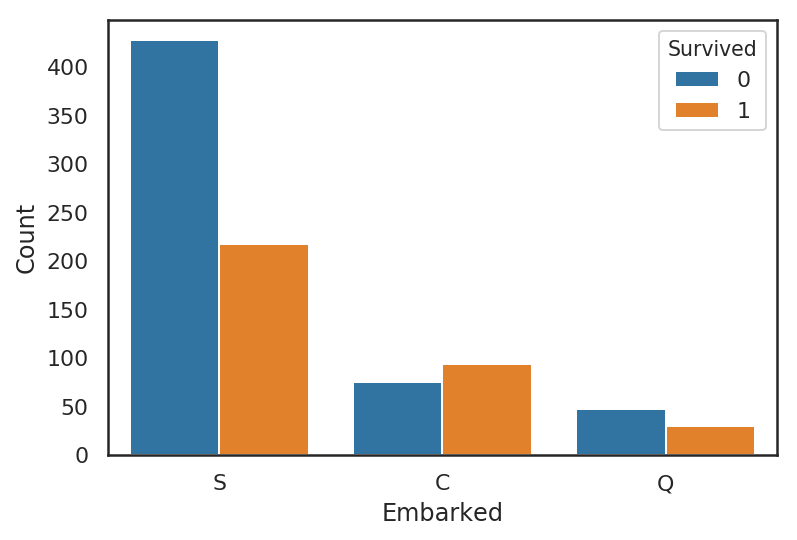

In [18]:
# Embarked
ax = sns.countplot(x='Embarked',hue='Survived',data=traindata)
ax.set_ylabel('Count')

traindata[['Embarked','Survived']].groupby(['Embarked']).count()

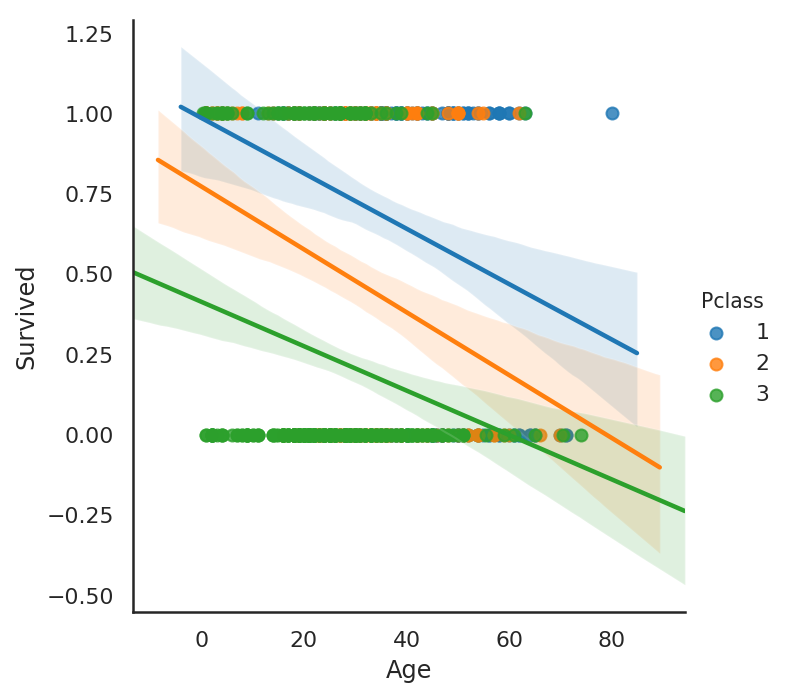

In [19]:
# Multiplots
# Age and Pclass

sns.lmplot('Age', 'Survived', data=traindata, hue='Pclass')

<Figure size 1152x384 with 0 Axes>

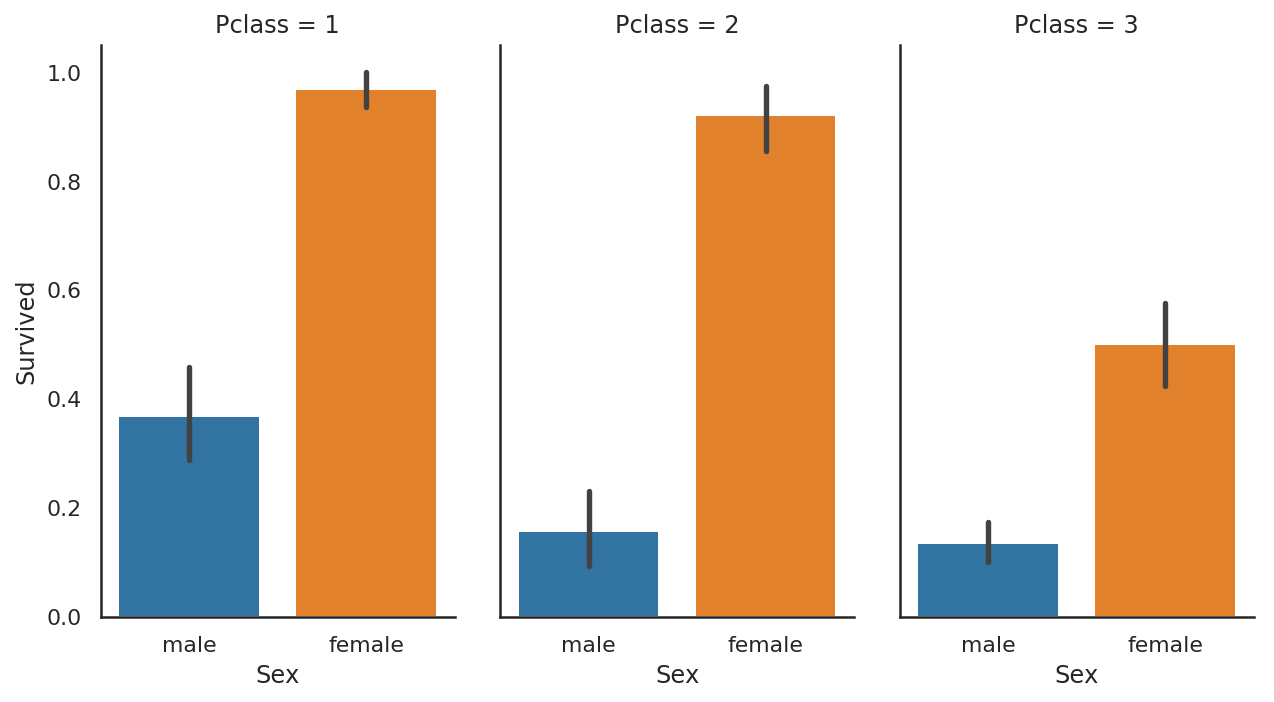

In [20]:
# Age, Sex and Pclass
fig = plt.figure(figsize=(12,4), dpi=96)
sns.catplot(x='Sex', y='Survived', col='Pclass', 
            data=traindata, kind='bar', aspect=0.6)

<Figure size 2688x384 with 0 Axes>

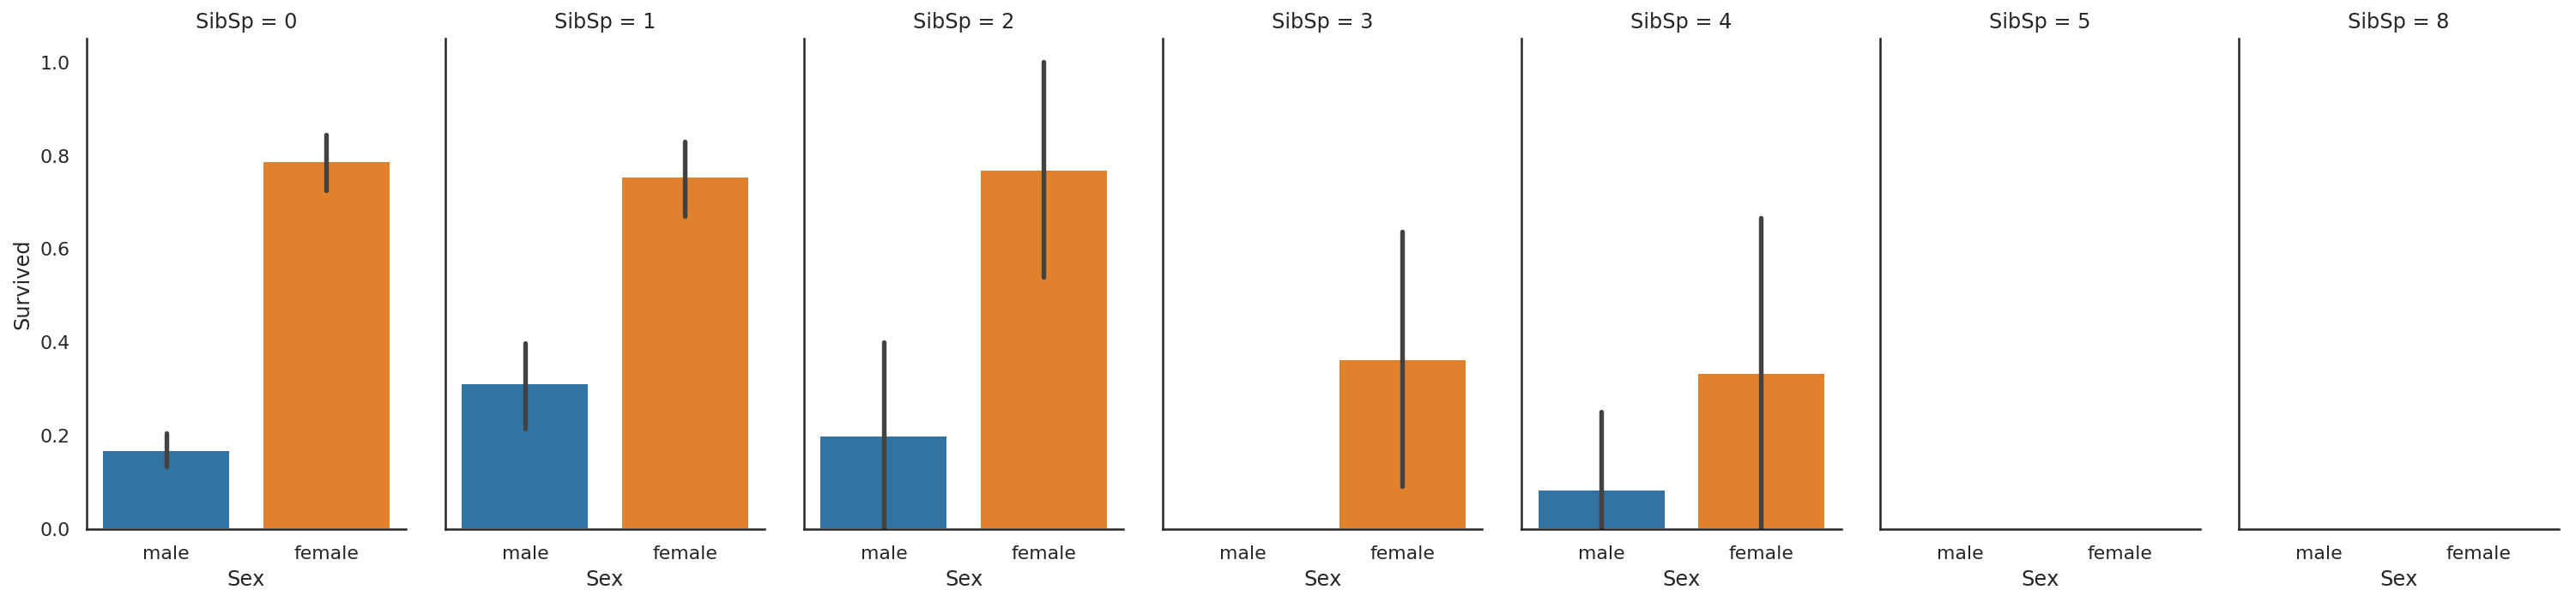

In [21]:
# Age, Sex, and Siblings on board
fig = plt.figure(figsize=(28,4), dpi=96)
sns.catplot(x='Sex', y='Survived', col='SibSp', 
            data=traindata, kind='bar', aspect=0.6)

<Figure size 2688x384 with 0 Axes>

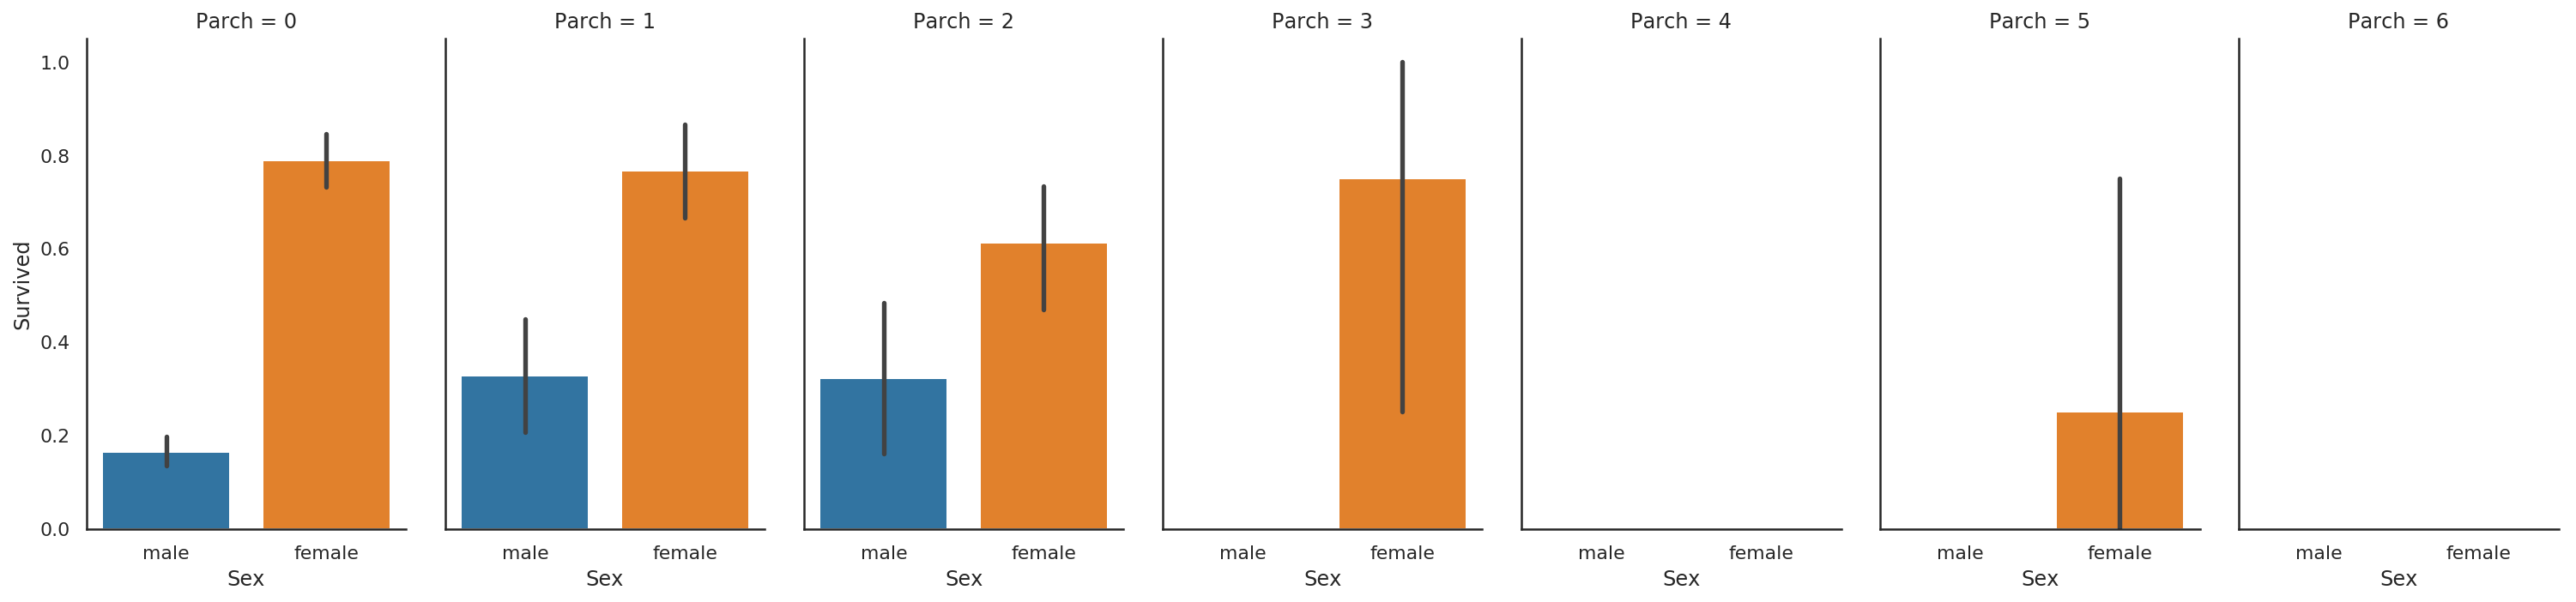

In [22]:
#Age, Sex and Parch
fig = plt.figure(figsize=(28,4), dpi=96)
sns.catplot(x='Sex', y='Survived', col='Parch', 
            data=traindata, kind='bar', aspect=0.6)

## Feature Engineering

In [23]:
# combining data

traindata['origin'] = 'train'
testdata['origin'] = 'test'
alldata = pd.concat([traindata, testdata], ignore_index=True, sort=False)
print(traindata.shape, testdata.shape, alldata.shape)
print(set(traindata.columns) - set(testdata.columns))

alldata.isna().sum()

(891, 13) (418, 12) (1309, 13)
{'Survived'}


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
origin            0
dtype: int64

In [24]:
alldata.set_index('PassengerId', inplace=True)
alldata.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,origin
PassengerId,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [25]:
# typecast survival to bool

alldata['Survived'] = alldata.Survived.map(lambda s: np.bool(s) if not \
                                           np.isnan(s) else np.nan)

alldata.loc[alldata.origin=='test', :].head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,origin
PassengerId,,,,,,,,,,,,
892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,test
893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,test
894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,test
895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,test
896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,test


Keeping a mix of Categorical and Numerical Columns, all discrete.

In [26]:
# Pclass - make categorical
alldata['Pclass'] = alldata.Pclass.astype('category')
alldata['Pclass'].value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [27]:
# Name - Extract Prefixes
alldata['Prefix'] = alldata.astype(str).apply(lambda s: pd.Series(apply_prefix(s["Name"])),axis=1)
print(alldata.Prefix.unique())
alldata['Prefix'] = alldata.Prefix.astype('category').cat.codes + 2
alldata['Prefix'] = alldata['Prefix'].astype('category')
alldata['Prefix'].value_counts()

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'Countess.' 'Jonkheer.' nan]


14    757
11    260
15    197
10     61
17      8
6       8
3       4
9       2
16      2
12      2
5       1
2       1
4       1
18      1
7       1
8       1
13      1
1       1
Name: Prefix, dtype: int64

In [28]:
# check progress
alldata.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'origin', 'Prefix'],
      dtype='object')

In [29]:
#Name -> Drop Raw Names
alldata.drop(labels = ['Name'], axis=1, inplace=True)
# check progress
alldata.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'origin', 'Prefix'],
      dtype='object')

In [30]:
#Sex -> Categorize
alldata['Sex'] = alldata.Sex.astype('category').cat.codes + 1
alldata['Sex'] = alldata.Sex.astype('category')
alldata['Sex'].value_counts(), alldata['Sex'].dtype

(2    843
 1    466
 Name: Sex, dtype: int64, CategoricalDtype(categories=[1, 2], ordered=False))

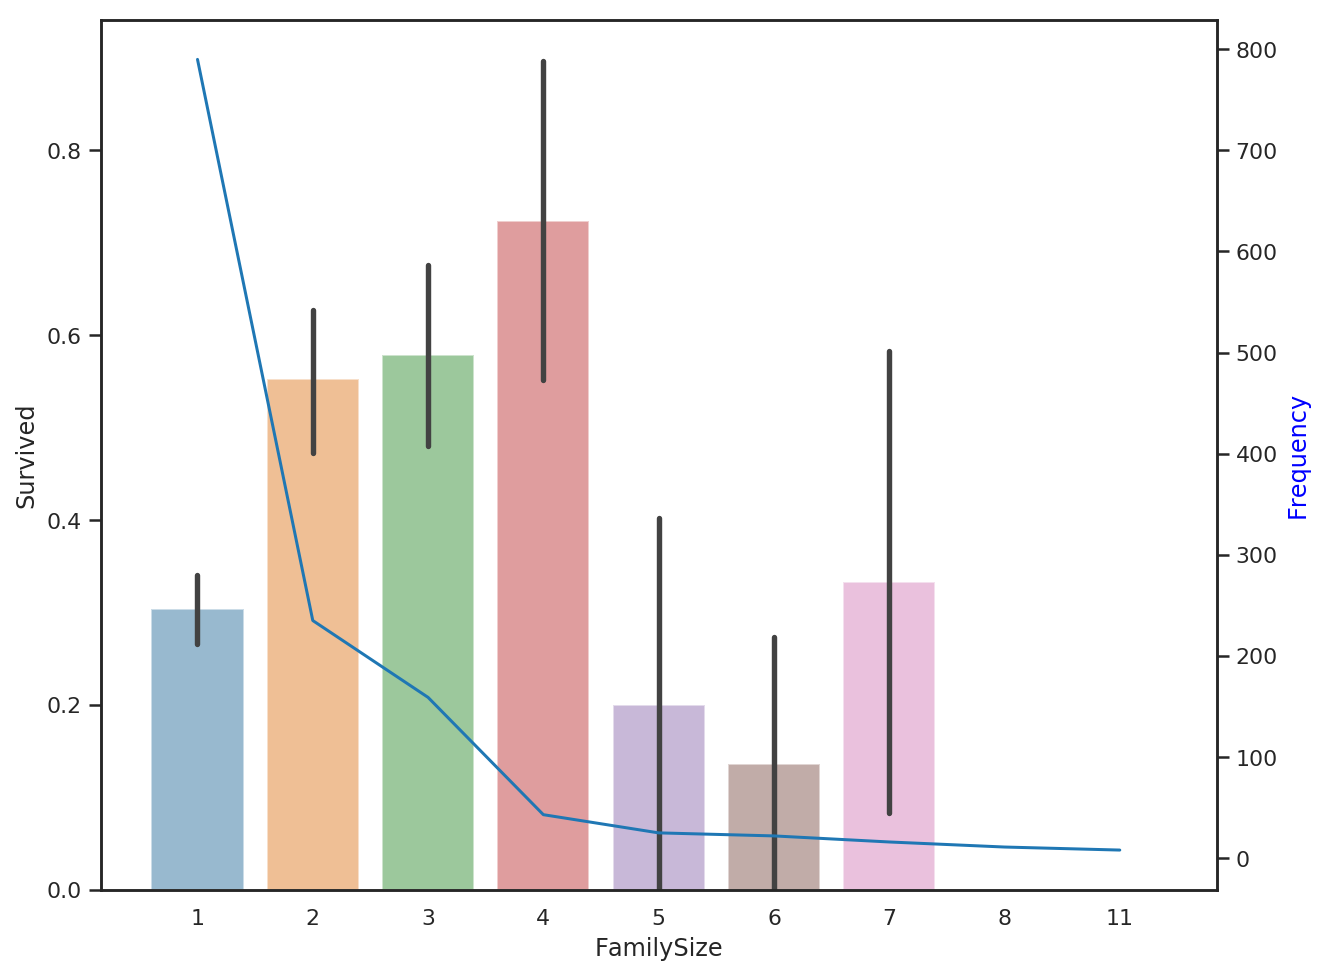

In [31]:
# SibSp and Parch -> Family Size

# switch of scipy.stats warning for enforced use of arr[np.array(seq)]
np.warnings.filterwarnings('ignore')

alldata[('FamilySize')] = alldata[('SibSp')] + alldata[('Parch')] + 1

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax = sns.barplot(x='FamilySize',y='Survived',data=alldata,alpha=0.5)
for c in ax.patches:
    c.set_zorder(0)

ax2 = ax.twinx()
_ = sns.lineplot(x=np.arange(0, len(alldata.FamilySize.unique())),
                        y=alldata.FamilySize.value_counts(),ax=ax2)

_ = ax2.set_ylabel('Frequency', color='b')

In [32]:
# Cat Codes for FamilySize, SibSp and Parch

alldata['FamilySize'] = alldata.FamilySize.astype(np.uint8)
print(alldata.FamilySize.value_counts(), alldata.FamilySize.dtype)

alldata['SibSp'] = alldata.SibSp.astype(np.uint8)
alldata['Parch'] = alldata.Parch.astype(np.uint8)

print(alldata.SibSp.value_counts(), alldata.SibSp.dtype)
print(alldata.Parch.value_counts(), alldata.Parch.dtype)

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: FamilySize, dtype: int64 uint8
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64 uint8
0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: Parch, dtype: int64 uint8


In [33]:
def parse_ticket(s:str)->(str, int):
    if s.strip(" ").isnumeric():
        return float('NaN'), int(s)
    elif s.strip(" ").isalpha():
        return s.strip(" "), int(0)
    else:
        try:
            xstr = s.replace('.','').replace('/','').strip(' ').split(' ')
            s,i = ''.join(xstr[0:-1]),xstr[-1]
            return s, int(i)
        except:
            xstr = s.replace('.','').replace('/','').strip(' ').split(' ')
            ss,i = ''.join(xstr[0:-1]),xstr[-1]
            print(s,ss, i)
    
alldata[["TKTHEADER","TKTNUM"]] = alldata.apply(lambda s: pd.Series(parse_ticket(s["Ticket"])),
                                                               axis=1)
alldata[['TKTHEADER','TKTNUM']].head()

,TKTHEADER,TKTNUM
PassengerId,,
1,A5,21171.0
2,PC,17599.0
3,STONO2,3101282.0
4,NaN,113803.0
5,NaN,373450.0


In [34]:
# cleaning up ticket data

alldata.drop(labels=['Ticket'], axis=1, inplace=True)

alldata['TKTHEADER'] = alldata.TKTHEADER.astype(str)
alldata['TKTNUM'] = alldata.TKTNUM.astype(np.int64)

alldata['TKTHEADER'] = alldata.TKTHEADER.astype('category').cat.codes + 1
alldata['TKTHEADER'] = alldata.TKTHEADER.astype('category')

alldata['TKTNUM'] = alldata.TKTNUM.astype('category').cat.codes + 1
alldata['TKTNUM'] = alldata.TKTNUM.astype('category')

print(alldata.TKTNUM.value_counts(), alldata.TKTNUM.dtype)
print(alldata.TKTHEADER.value_counts(), alldata.TKTHEADER.dtype)

40     11
25      8
18      8
909     7
671     7
666     7
269     7
219     7
448     6
676     6
856     6
293     6
278     5
134     5
436     5
752     5
474     5
224     5
149     5
74      4
81      4
148     4
189     4
370     4
442     4
361     4
230     4
39      4
481     4
380     4
       ..
571     1
570     1
569     1
592     1
594     1
618     1
607     1
617     1
616     1
615     1
614     1
613     1
612     1
611     1
610     1
609     1
608     1
606     1
595     1
605     1
604     1
603     1
602     1
601     1
600     1
599     1
598     1
597     1
596     1
462     1
Name: TKTNUM, Length: 924, dtype: int64 category
37    957
15     92
8      68
3      28
30     24
32     21
35     15
24     14
2      10
11      9
7       8
26      8
28      7
25      5
13      4
36      4
21      4
16      4
10      3
29      3
18      2
17      2
20      2
34      2
6       1
9       1
4       1
5       1
19      1
12      1
14      1
22      1
23      1
27      1
3

In [35]:
# Cabins

def parse_cabin(s):
    
    Decks = ['A','B','C','D','E','F','G','T']
    DeckSet = set()
    sc = s
    
    if type(s)==float:
        return float('NaN'), float('NaN')
    else:
        for deck_ in Decks:
            if deck_ in s:
                DeckSet.add(deck_)
                s = s.replace(deck_,"")
        if s == "":
            return tuple(DeckSet), float('NaN')
        else:
            Rooms = tuple(int(_s) for _s in s.strip(' ').split(' '))
            return tuple(DeckSet), tuple(Rooms)
        
alldata[['Deck','Cabin']] = alldata.apply(lambda s: pd.Series(parse_cabin(s["Cabin"])),axis=1)
alldata.loc[alldata['Deck'].notnull(), ('Deck','Cabin')].head()

,Deck,Cabin
PassengerId,,
2,"(C,)","(85,)"
4,"(C,)","(123,)"
7,"(E,)","(46,)"
11,"(G,)","(6,)"
12,"(C,)","(103,)"


In [36]:
alldata['Deck'] = alldata['Deck'].map(lambda s: 'N/A' if type(s)!=tuple else ''.join(s))
alldata['Cabin'] = alldata['Cabin'].map(lambda s: 'N/A' if type(s)!=tuple else len(s))
alldata.Deck.unique(), alldata.Cabin.unique()

(array(['N/A', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'FG', 'FE', 'T'],
       dtype=object), array(['N/A', 1, 3, 2, 4], dtype=object))

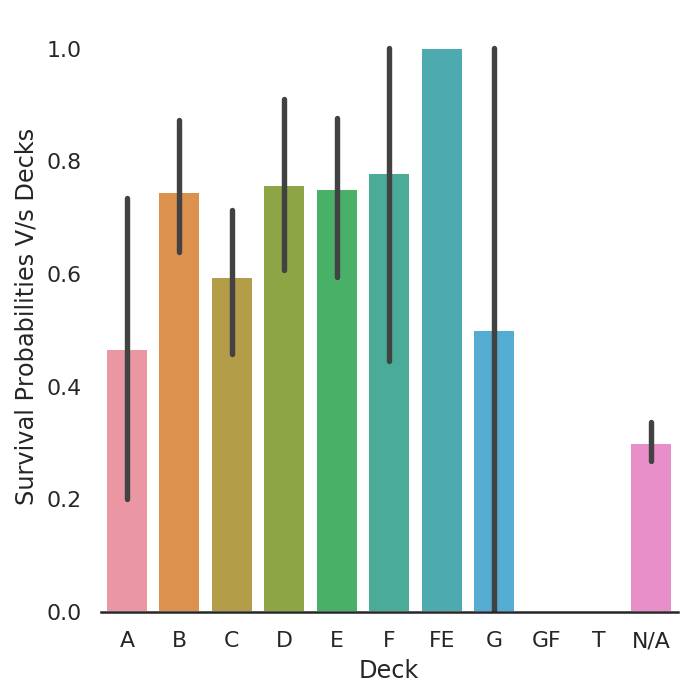

In [37]:
ax_dk  = sns.factorplot(x="Deck",y="Survived",data=alldata,kind="bar"
                        ,order=['A','B','C','D','E','F','FE','G','GF','T','N/A'])
ax_dk.despine(left=True)
ax_dk = ax_dk.set_ylabels("Survival Probabilities V/s Decks")

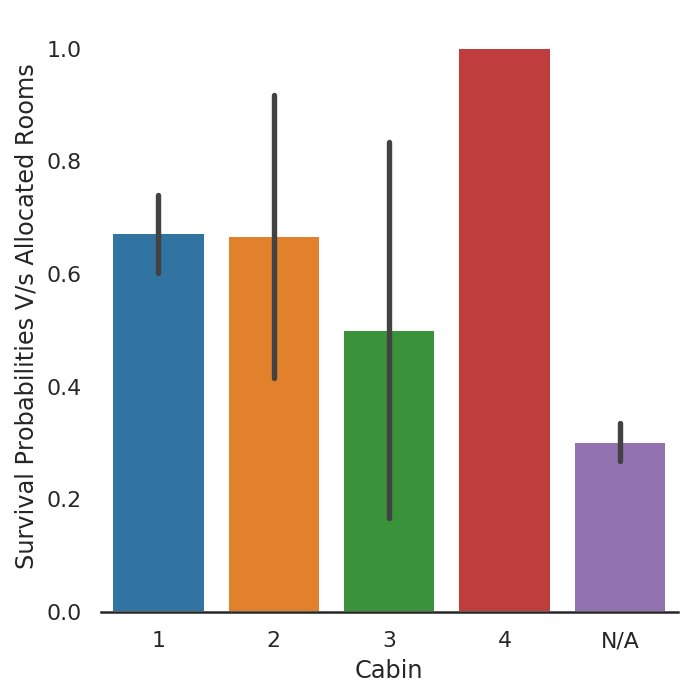

In [38]:
ax_cb  = sns.factorplot(x="Cabin",y="Survived",data=alldata,kind="bar"
                        ,order=[1,2,3,4,'N/A'])
ax_cb.despine(left=True)
ax_cb = ax_cb.set_ylabels("Survival Probabilities V/s Allocated Rooms")

In [39]:
alldata['Deck'] = alldata.Deck.astype('category').cat.codes + 1
alldata['Cabin'] = alldata.Cabin.astype('category').cat.codes + 1
alldata['Deck'] = alldata.Deck.astype('category')
alldata['Cabin'] = alldata.Cabin.astype('category')
print(alldata.Deck.value_counts(), alldata.Deck.dtype)
print(alldata.Cabin.value_counts(), alldata.Cabin.dtype)

10    1014
3       94
2       65
4       46
5       41
1       22
6       14
9        5
8        4
7        3
11       1
Name: Deck, dtype: int64 category
5    1020
1     255
2      19
3      10
4       5
Name: Cabin, dtype: int64 category


In [40]:
# check progress
print(list(alldata.columns))

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'origin', 'Prefix', 'FamilySize', 'TKTHEADER', 'TKTNUM', 'Deck']


### Imputation for Age, Fare & Embarked

In [41]:
def KNNfill(df,usecols,predcol, knn_k=5):
    
    dfcpy = df.copy().fillna(value=float('NaN')).loc[:, usecols]
    minval = dfcpy.loc[dfcpy[predcol].notnull(),(predcol)].min()
    meanval = dfcpy.loc[dfcpy[predcol].notnull(),(predcol)].mean()
    maxval = dfcpy.loc[dfcpy[predcol].notnull(),(predcol)].max()
    
    predictor = KNN(k=knn_k, min_value=minval, max_value=maxval)
    print("Starting Imputation, Printing NaNs for Passed DataFrame::\n{}\n".format(dfcpy.isnull().sum()))
    print("{} values missing for {}".format(dfcpy[predcol].isnull().sum(),predcol))
    imputed_df = pd.DataFrame(data=predictor.fit_transform(dfcpy),
                             columns=usecols)
    imputed_df.index = dfcpy.index
    imputed_df['orig_'+predcol] = dfcpy.loc[:, (predcol)]
    return imputed_df

In [42]:
usecols = ['Pclass', 'Sex', 'Age', 'SibSp',
           'Parch', 'Fare', 'Cabin', 'Prefix',
           'FamilySize', 'TKTHEADER', 'TKTNUM',
           'Deck']

# fill Fare with mean
tempfare = alldata.copy()
tempfare.loc[np.isnan(alldata.Fare),['Fare']] = tempfare.loc[:,'Fare'].mean()

imputed_df = KNNfill(tempfare, usecols, 'Age')

print("OK!" if imputed_df.Age.isnull().sum()==0 else "Imputation Failed!")

# compare with Original NaN's
imputed_df.loc[imputed_df['orig_Age'].isnull(),('orig_Age','Age')].head()
imputed_df['Survived'] = alldata.Survived

print(f'Min:{imputed_df.Age.min()} Max:{imputed_df.Age.max()}')

Starting Imputation, Printing NaNs for Passed DataFrame::
Pclass          0
Sex             0
Age           263
SibSp           0
Parch           0
Fare            0
Cabin           0
Prefix          0
FamilySize      0
TKTHEADER       0
TKTNUM          0
Deck            0
dtype: int64

263 values missing for Age
Imputing row 1/1309 with 0 missing, elapsed time: 0.199
Imputing row 101/1309 with 0 missing, elapsed time: 0.200
Imputing row 201/1309 with 0 missing, elapsed time: 0.201
Imputing row 301/1309 with 1 missing, elapsed time: 0.201
Imputing row 401/1309 with 0 missing, elapsed time: 0.202
Imputing row 501/1309 with 0 missing, elapsed time: 0.203
Imputing row 601/1309 with 0 missing, elapsed time: 0.203
Imputing row 701/1309 with 0 missing, elapsed time: 0.204
Imputing row 801/1309 with 0 missing, elapsed time: 0.205
Imputing row 901/1309 with 0 missing, elapsed time: 0.205
Imputing row 1001/1309 with 0 missing, elapsed time: 0.206
Imputing row 1101/1309 with 0 missing, elapsed t

,orig_Age,Age
PassengerId,,
6,NaN,26.114932
18,NaN,27.964362
20,NaN,22.827201
27,NaN,36.683059
29,NaN,18.813799


Min:0.17 Max:80.0


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


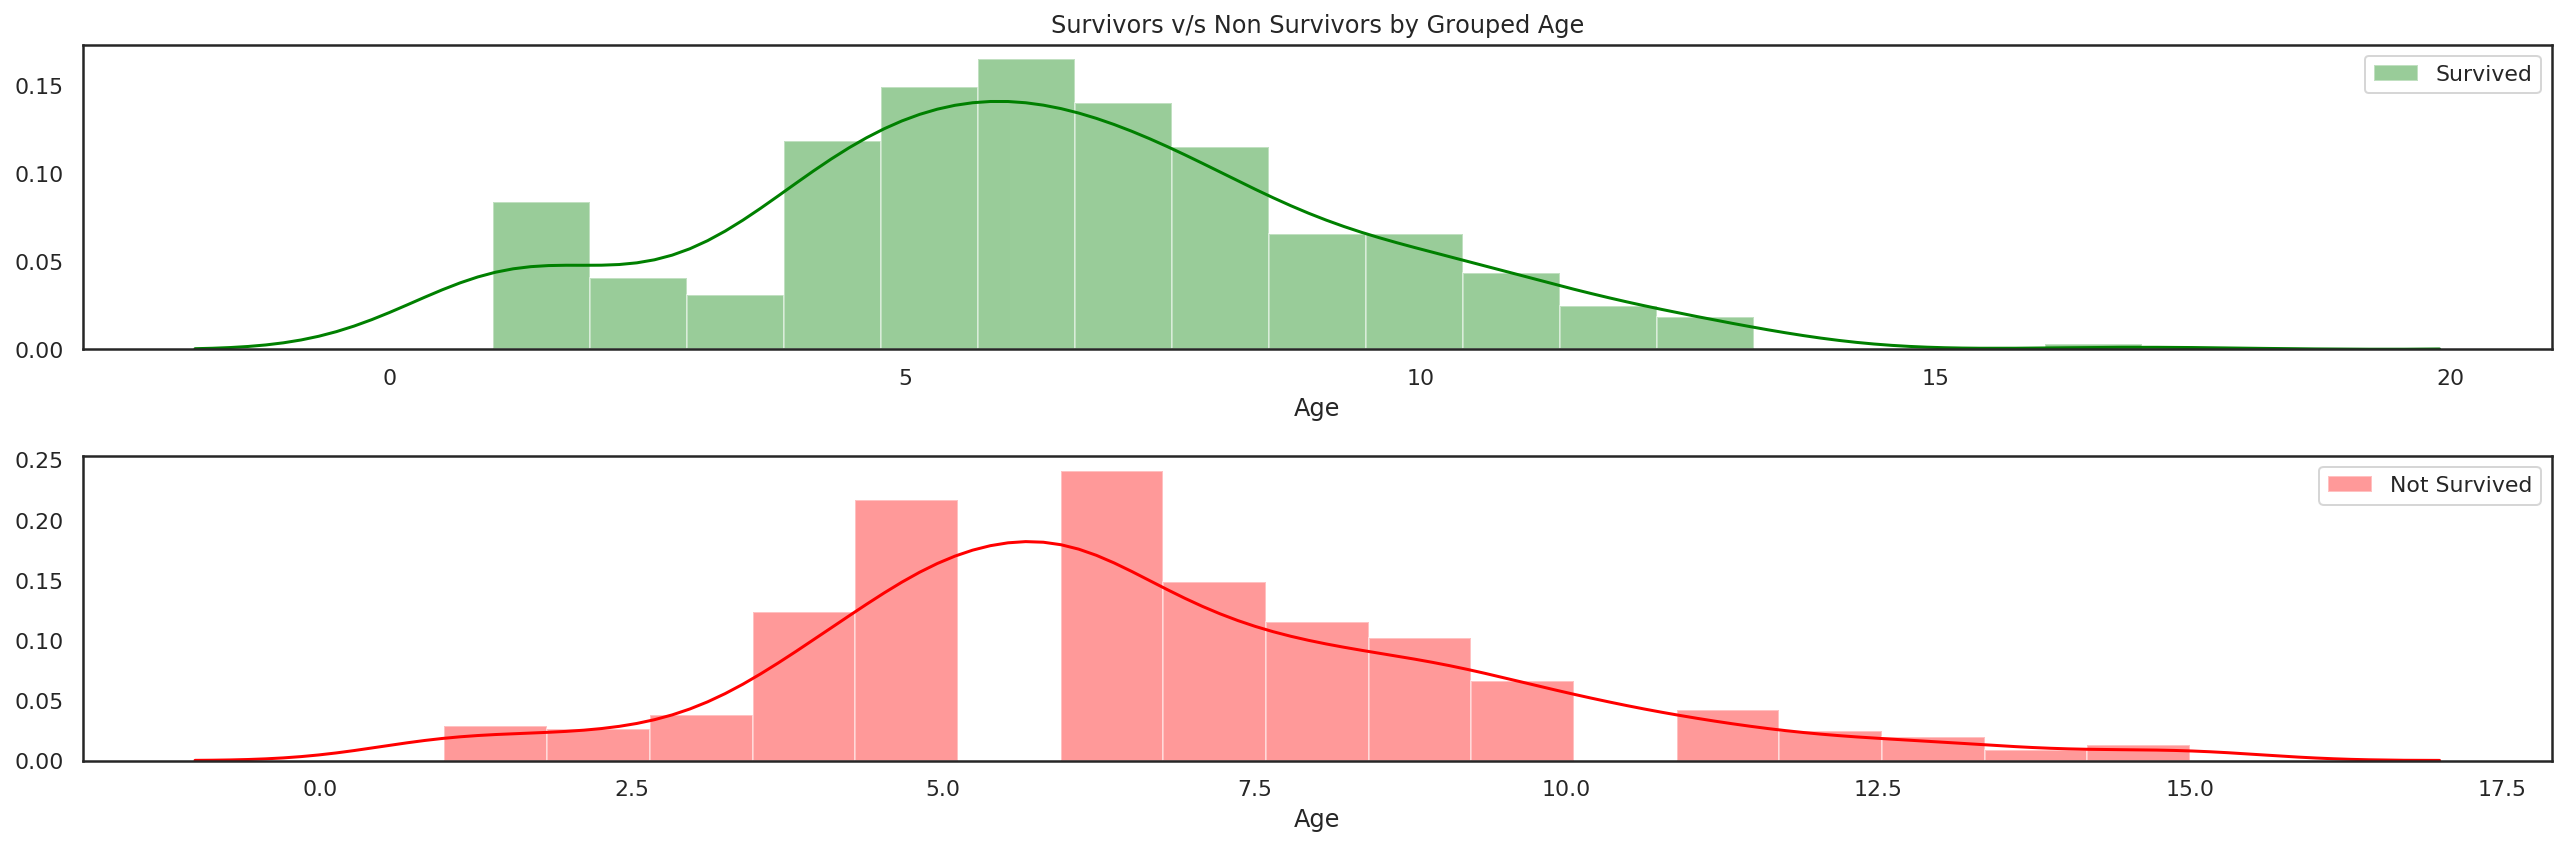

In [43]:
# discretize age to 10 year bins.

imputed_df['Age'] = imputed_df['Age'].map(lambda s: int((int(s)//5)+1))
imputed_df['Age'] = imputed_df['Age'].astype(np.int8)
print(np.sort(imputed_df.Age.unique()))

# plot
fig, ax_ag = plt.subplots(2, 1, figsize=(18,6))

ax_ag[0] = sns.distplot(imputed_df.loc[(imputed_df['Survived']==1),('Age')], 
                        bins=17, color='g', kde=True, hist=True,
                        label='Survived', ax = ax_ag[0])
ax_ag[1] = sns.distplot(imputed_df.loc[(imputed_df['Survived']==0),('Age')],
                        bins=17, color='r', kde=True, hist=True,
                        label='Not Survived', ax = ax_ag[1])
_ = ax_ag[0].set_title('Survivors v/s Non Survivors by Grouped Age', loc='center')
_ = ax_ag[0].legend()
_ = ax_ag[1].legend()
plt.tight_layout()

In [44]:
# assign and cast
alldata['Age'] = imputed_df.Age
alldata['Age'] = alldata.Age.astype(np.uint8)
alldata['Age'].value_counts()

5     240
6     235
7     161
4     131
8     125
9      91
10     80
1      51
11     46
3      40
2      37
12     32
13     27
15      6
14      5
16      1
17      1
Name: Age, dtype: int64

In [45]:
# Fares
print(alldata['Fare'].isnull().sum())

usecols = set(alldata.columns) - set(['Survived','origin','Embarked'])
predcol = 'Fare'

imputed_df = KNNfill(alldata,usecols,predcol,100)

1
Starting Imputation, Printing NaNs for Passed DataFrame::
Fare          1
Pclass        0
Parch         0
Prefix        0
FamilySize    0
TKTHEADER     0
Deck          0
TKTNUM        0
Cabin         0
Sex           0
SibSp         0
Age           0
dtype: int64

1 values missing for Fare
Imputing row 1/1309 with 0 missing, elapsed time: 0.196
Imputing row 101/1309 with 0 missing, elapsed time: 0.197
Imputing row 201/1309 with 0 missing, elapsed time: 0.197
Imputing row 301/1309 with 0 missing, elapsed time: 0.197
Imputing row 401/1309 with 0 missing, elapsed time: 0.197
Imputing row 501/1309 with 0 missing, elapsed time: 0.197
Imputing row 601/1309 with 0 missing, elapsed time: 0.197
Imputing row 701/1309 with 0 missing, elapsed time: 0.198
Imputing row 801/1309 with 0 missing, elapsed time: 0.198
Imputing row 901/1309 with 0 missing, elapsed time: 0.198
Imputing row 1001/1309 with 0 missing, elapsed time: 0.198
Imputing row 1101/1309 with 0 missing, elapsed time: 0.198
Imputing row

Median:17.24718360897142, Predicted:33.2954792813456


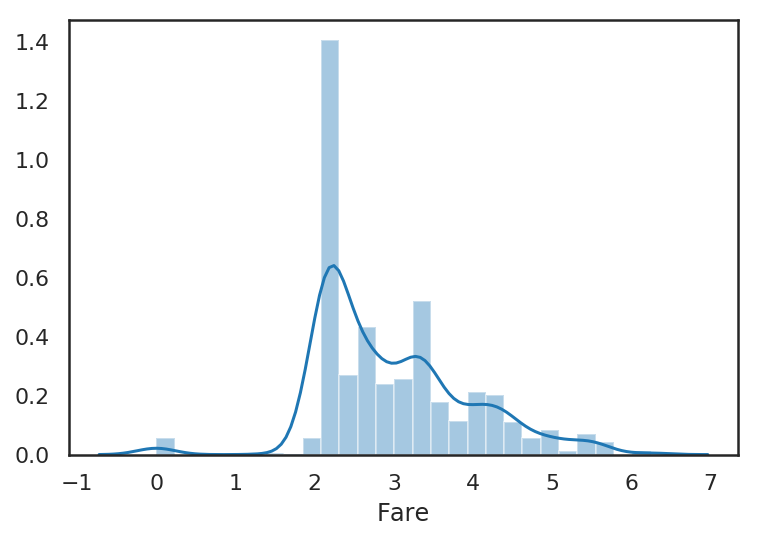

In [46]:
comp_fares = (float(imputed_df.loc[imputed_df['orig_Fare'].isnull(),('Fare')]),
              imputed_df.orig_Fare.mean())

print('Median:{}, Predicted:{}'.format(*comp_fares))

# logshift fares value 
alldata['Fare'] = np.log1p(imputed_df['Fare'])

sns.distplot(alldata['Fare'])

In [47]:
# discretizing fares

alldata['Fare'] = alldata['Fare'].map(lambda s: int(s/0.25)+1)
alldata['Fare'] = alldata.Fare.astype(np.uint8)
print(alldata.Fare.value_counts())

9     409
14    176
11    138
10    104
13     77
12     73
18     72
16     49
15     48
17     45
19     26
20     20
22     18
1      17
23     16
21     13
25      4
8       2
7       1
6       1
Name: Fare, dtype: int64


In [48]:
# Embarked
alldata['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [49]:
EmbMap = {'C':0, 'Q':1, 'S':2}

alldata['Embarked'] = alldata['Embarked'].map(lambda s: np.nan if type(s)==float else EmbMap[str(s)])

alldata['Embarked'].isnull().sum()

2

In [50]:
usecols = set(alldata.columns) - set(['Survived','origin'])
predcol = 'Embarked'

imputed_df = KNNfill(alldata,usecols,predcol,100)

Starting Imputation, Printing NaNs for Passed DataFrame::
Fare          0
Pclass        0
Parch         0
Prefix        0
FamilySize    0
TKTHEADER     0
Deck          0
TKTNUM        0
Cabin         0
Sex           0
Embarked      2
SibSp         0
Age           0
dtype: int64

2 values missing for Embarked
Imputing row 1/1309 with 0 missing, elapsed time: 0.191
Imputing row 101/1309 with 0 missing, elapsed time: 0.191
Imputing row 201/1309 with 0 missing, elapsed time: 0.191
Imputing row 301/1309 with 0 missing, elapsed time: 0.192
Imputing row 401/1309 with 0 missing, elapsed time: 0.192
Imputing row 501/1309 with 0 missing, elapsed time: 0.192
Imputing row 601/1309 with 0 missing, elapsed time: 0.192
Imputing row 701/1309 with 0 missing, elapsed time: 0.192
Imputing row 801/1309 with 0 missing, elapsed time: 0.193
Imputing row 901/1309 with 0 missing, elapsed time: 0.193
Imputing row 1001/1309 with 0 missing, elapsed time: 0.193
Imputing row 1101/1309 with 0 missing, elapsed time: 

In [51]:
alldata['Embarked'] = imputed_df['Embarked']
alldata['Embarked'] = alldata.Embarked.map(lambda s: int(s))

alldata.Embarked.value_counts()

2    914
0    270
1    125
Name: Embarked, dtype: int64

In [52]:
# cat codes, meow!
alldata['Embarked'] = alldata.Embarked.astype('category').cat.codes + 1
alldata['Embarked'] = alldata.Embarked.astype('category')
print(alldata.Embarked.value_counts())
print('\n',list(alldata.columns))

3    914
1    270
2    125
Name: Embarked, dtype: int64

 ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'origin', 'Prefix', 'FamilySize', 'TKTHEADER', 'TKTNUM', 'Deck']


### Verification

In [53]:
# forced typecasting

alldata['origin'] = alldata.origin.astype('category')
typesdict = {'object':[], 'categorical':[], 'numerical':[]}
uint8check = lambda x: True if x.max() <= 255 else False

for col in alldata.columns:
    safestr = ''
    try:
        safestr = 'YES' if uint8check(alldata[col]) else '(!) NO'
        if uint8check(alldata[col]):
            alldata[col] = alldata[col].astype(np.uint8)
            typesdict['numerical'].append(str(col))
    except:
        print('(!) Exception at: ',col)
        safestr = '(!) NO'
        if str(alldata[col].dtype)=='category':
            typesdict['categorical'].append(str(col))
        elif alldata[col].dtype=='object':
            typesdict['object'].append(str(col))
    print("{}: UINT8 Safe:\033[1m{}\033[0m, Type:{}".format(col,
                                            safestr,
                                            alldata[col].dtype))



print(f'\n\n {typesdict}')

(!) Exception at:  Survived
Survived: UINT8 Safe:(!) NO, Type:object
(!) Exception at:  Pclass
Pclass: UINT8 Safe:(!) NO, Type:category
(!) Exception at:  Sex
Sex: UINT8 Safe:(!) NO, Type:category
Age: UINT8 Safe:YES, Type:uint8
SibSp: UINT8 Safe:YES, Type:uint8
Parch: UINT8 Safe:YES, Type:uint8
Fare: UINT8 Safe:YES, Type:uint8
(!) Exception at:  Cabin
Cabin: UINT8 Safe:(!) NO, Type:category
(!) Exception at:  Embarked
Embarked: UINT8 Safe:(!) NO, Type:category
(!) Exception at:  origin
origin: UINT8 Safe:(!) NO, Type:category
(!) Exception at:  Prefix
Prefix: UINT8 Safe:(!) NO, Type:category
FamilySize: UINT8 Safe:YES, Type:uint8
(!) Exception at:  TKTHEADER
TKTHEADER: UINT8 Safe:(!) NO, Type:category
(!) Exception at:  TKTNUM
TKTNUM: UINT8 Safe:(!) NO, Type:category
(!) Exception at:  Deck
Deck: UINT8 Safe:(!) NO, Type:category


 {'object': ['Survived'], 'categorical': ['Pclass', 'Sex', 'Cabin', 'Embarked', 'origin', 'Prefix', 'TKTHEADER', 'TKTNUM', 'Deck'], 'numerical': ['Age', 'Si

### Using Feature Tools for DFS

In [ ]:
# prep test, train df for ft 

ft_train = alldata.loc[alldata.origin=='train',:].copy().drop(labels=['origin'],
                                                              axis=1)
ft_train.rename_axis('PassengerId', inplace=True)

ft_test = alldata.loc[alldata.origin=='test',:].copy().drop(labels=['origin'],
                                                            axis=1)
ft_test.rename_axis('PassengerId', inplace=True)

In [54]:
ft_data = alldata.copy()
ft_data.drop(labels=['Survived','origin'], inplace=True, axis=1)

In [55]:
import featuretools as ft

es = ft.EntitySet(id='Survived')

variable_types_dict = {'PassengerId': ft.variable_types.Index,
                       'Pclass': ft.variable_types.Categorical,
                       'Sex': ft.variable_types.Categorical,
                       'Age': ft.variable_types.Numeric,
                       'SibSp' : ft.variable_types.Numeric,
                       'Parch' : ft.variable_types.Numeric,
                       'Fare' : ft.variable_types.Numeric,
                       'Cabin' : ft.variable_types.Categorical,
                       'Embarked' : ft.variable_types.Categorical,
                       'Prefix' : ft.variable_types.Categorical,
                       'FamilySize' : ft.variable_types.Numeric,
                       'TKTHEADER' : ft.variable_types.Categorical,
                       'TKTNUM' : ft.variable_types.Categorical,
                       'Deck' : ft.variable_types.Categorical}

es = es.entity_from_dataframe(entity_id='alldata',
                              dataframe=ft_data,
                              index='PassengerId',
                              variable_types=variable_types_dict)
print(es['alldata'].variables)
es

2019-01-10 06:08:29,483 featuretools.entityset - WARNING    index PassengerId not found in dataframe, creating new integer column
[<Variable: PassengerId (dtype = index)>, <Variable: Pclass (dtype = categorical)>, <Variable: Sex (dtype = categorical)>, <Variable: Age (dtype = numeric)>, <Variable: SibSp (dtype = numeric)>, <Variable: Parch (dtype = numeric)>, <Variable: Fare (dtype = numeric)>, <Variable: Cabin (dtype = categorical)>, <Variable: Embarked (dtype = categorical)>, <Variable: Prefix (dtype = categorical)>, <Variable: FamilySize (dtype = numeric)>, <Variable: TKTHEADER (dtype = categorical)>, <Variable: TKTNUM (dtype = categorical)>, <Variable: Deck (dtype = categorical)>]


Entityset: Survived
  Entities:
    alldata [Rows: 1309, Columns: 14]
  Relationships:
    No relationships

In [56]:

entities = set(variable_types_dict.keys()) - {'PassengerId'} 

for entity in entities:
    es = es.normalize_entity(base_entity_id='alldata', 
                             new_entity_id=entity,
                             index='PassengerId')
    
es

Entityset: Survived
  Entities:
    alldata [Rows: 1309, Columns: 14]
    Fare [Rows: 1309, Columns: 1]
    Pclass [Rows: 1309, Columns: 1]
    Parch [Rows: 1309, Columns: 1]
    Prefix [Rows: 1309, Columns: 1]
    FamilySize [Rows: 1309, Columns: 1]
    TKTHEADER [Rows: 1309, Columns: 1]
    Deck [Rows: 1309, Columns: 1]
    TKTNUM [Rows: 1309, Columns: 1]
    Cabin [Rows: 1309, Columns: 1]
    Sex [Rows: 1309, Columns: 1]
    Embarked [Rows: 1309, Columns: 1]
    SibSp [Rows: 1309, Columns: 1]
    Age [Rows: 1309, Columns: 1]
  Relationships:
    alldata.PassengerId -> Fare.PassengerId
    alldata.PassengerId -> Pclass.PassengerId
    alldata.PassengerId -> Parch.PassengerId
    alldata.PassengerId -> Prefix.PassengerId
    alldata.PassengerId -> FamilySize.PassengerId
    alldata.PassengerId -> TKTHEADER.PassengerId
    alldata.PassengerId -> Deck.PassengerId
    alldata.PassengerId -> TKTNUM.PassengerId
    alldata.PassengerId -> Cabin.PassengerId
    alldata.PassengerId -> Sex.Pas

In [57]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 40

primitives[primitives['type'] == 'aggregation']

,name,type,description
0,median,aggregation,Finds the median value of any featur...
1,num_true,aggregation,Finds the number of 'True' values in...
2,time_since_last,aggregation,Time since last related instance.
3,avg_time_between,aggregation,Computes the average time between co...
4,mode,aggregation,Finds the most common element in a c...
5,all,aggregation,Test if all values are 'True'.
6,n_most_common,aggregation,Finds the N most common elements in ...
7,num_unique,aggregation,Returns the number of unique categor...
8,max,aggregation,Finds the maximum non-null value of ...
9,mean,aggregation,Computes the average value of a nume...


#### generate features

In [58]:
features, feature_names = ft.dfs(entityset = es, 
                                 target_entity = 'alldata', 
                                 max_depth = len(entities))

In [154]:
len(features.columns)

611

In [60]:
feature_names

[<Feature: Pclass>,
 <Feature: Sex>,
 <Feature: Age>,
 <Feature: SibSp>,
 <Feature: Parch>,
 <Feature: Fare>,
 <Feature: Cabin>,
 <Feature: Embarked>,
 <Feature: Prefix>,
 <Feature: FamilySize>,
 <Feature: TKTHEADER>,
 <Feature: TKTNUM>,
 <Feature: Deck>,
 <Feature: Fare.SUM(alldata.Age)>,
 <Feature: Fare.SUM(alldata.SibSp)>,
 <Feature: Fare.SUM(alldata.Parch)>,
 <Feature: Fare.SUM(alldata.Fare)>,
 <Feature: Fare.SUM(alldata.FamilySize)>,
 <Feature: Fare.STD(alldata.Age)>,
 <Feature: Fare.STD(alldata.SibSp)>,
 <Feature: Fare.STD(alldata.Parch)>,
 <Feature: Fare.STD(alldata.Fare)>,
 <Feature: Fare.STD(alldata.FamilySize)>,
 <Feature: Fare.MAX(alldata.Age)>,
 <Feature: Fare.MAX(alldata.SibSp)>,
 <Feature: Fare.MAX(alldata.Parch)>,
 <Feature: Fare.MAX(alldata.Fare)>,
 <Feature: Fare.MAX(alldata.FamilySize)>,
 <Feature: Fare.SKEW(alldata.Age)>,
 <Feature: Fare.SKEW(alldata.SibSp)>,
 <Feature: Fare.SKEW(alldata.Parch)>,
 <Feature: Fare.SKEW(alldata.Fare)>,
 <Feature: Fare.SKEW(alldata.Famil

#### reducing dimensionality

Since we have 638 features, need to prune them by a lot!

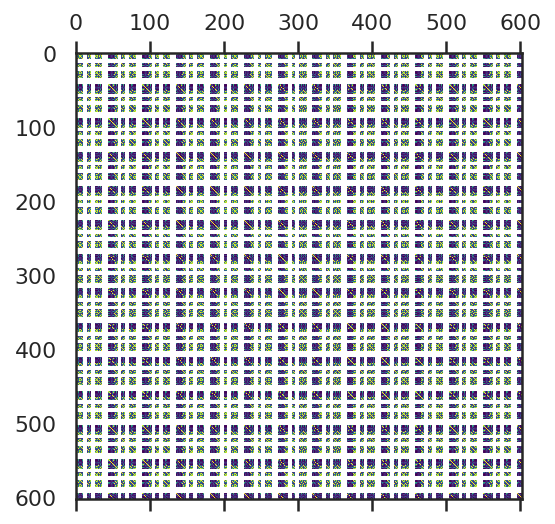

In [155]:
# Threshold for removing correlated variables
threshold = 0.9999

# Absolute value correlation matrix
corr_matrix = features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
plt.matshow(corr_matrix, cmap='viridis')

In [156]:
# Select columns with correlations above threshold
collinear_features = [column for column in upper.columns if any(upper[column] >= threshold)]

print('There are %d features to remove.' % (len(collinear_features)))

There are 356 features to remove.


In [157]:
features_filtered = features.drop(columns = collinear_features)

print('The number of features that passed the collinearity threshold: ', features_filtered.shape[1])

The number of features that passed the collinearity threshold:  255


##### guiding on relevant features with linear model with l1 norm

In [158]:
features_positive = features_filtered.loc[:, features_filtered.ge(0).all()]

X_train = features_positive[:traindata.shape[0]]
Y_train = traindata['Survived']

X_test = features_positive[traindata.shape[0]:]

In [162]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l2", dual=False).fit(X_train, Y_train)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_train)

X_train_selected = pd.DataFrame(X_new, columns=[X_train.columns[i] for i in range(len(X_train.columns)) if model.get_support()[i]])
X_train_selected.shape

(891, 10)

In [66]:
X_mytrain = alldata.copy().loc[alldata['origin']=='train',:].drop(labels=['Survived','origin'], axis=1)
print(X_mytrain.shape)

lsvc = LinearSVC(C=0.01, penalty="l2", dual=False).fit(X_mytrain, Y_train)

model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_mytrain)
print(X_new.shape)
X_mytrain_selected = pd.DataFrame(X_new, columns=[X_mytrain.columns[i] for i in range(len(X_mytrain.columns)) if model.get_support()[i]])
print(X_mytrain_selected.shape, X_mytrain_selected.columns)
allcols = set(alldata.columns) - {'Survived','origin'}
print(f'\nDiscarded Columns:\n{[col for col in allcols if col not in X_mytrain_selected.columns]}')

(891, 13)
(891, 3)
(891, 3) Index(['Sex', 'SibSp', 'Cabin'], dtype='object')

Discarded Columns:
['Fare', 'Pclass', 'Parch', 'Prefix', 'FamilySize', 'TKTHEADER', 'Deck', 'TKTNUM', 'Embarked', 'Age']


In [163]:
X_test_selected = X_test.loc[:, X_train_selected.columns]
X_test_selected.head()

,Pclass,Sex,Age,SibSp,Fare,Cabin,FamilySize,Fare.MODE(alldata.Pclass),Fare.MODE(alldata.Sex),Fare.MODE(alldata.Cabin)
PassengerId,,,,,,,,,,
891,3,2,7,0,9,5,1,3,2,5
892,3,1,10,1,9,5,2,3,1,5
893,2,2,13,0,10,5,1,2,2,5
894,3,2,6,0,10,5,1,3,2,5
895,3,1,5,1,11,5,3,3,1,5


In [126]:
for col in X_test_selected.columns:
    print(X_test_selected[col].isna().sum())
    try:
        print(X_test_selected[col].max().sum())
        print(X_test_selected[col].min().sum())
    except:
        print(col, X_test_selected[col].dtype)
        print(X_test_selected[col].value_counts())

0
Pclass category
3    218
1    107
2     93
Name: Pclass, dtype: int64
0
Sex category
2    266
1    152
Name: Sex, dtype: int64
0
16
1
0
8
0
0
25
1
0
Cabin category
5    329
1     75
2      7
3      4
4      3
Name: Cabin, dtype: int64
0
11
1
0
3
1
0
2
1
0
5
1


In [164]:
print([X_train_selected[col].dtype for col in  X_train_selected.columns])
print([X_train_selected[col].nunique() for col in  X_train_selected.columns])
print([X_train_selected[col].max() for col in  X_train_selected.columns])

for cols in  X_train_selected.columns:
    X_train_selected[cols] = X_train_selected[cols].astype('int')
    
for cols in  X_test_selected.columns:
    X_test_selected[cols] = X_test_selected[cols].astype(np.int)

[dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O')]
[3, 2, 16, 7, 19, 5, 9, 3, 2, 5]
[3, 2, 17, 8, 25, 5, 11, 3, 2, 5]


In [165]:
X_test_selected

,Pclass,Sex,Age,SibSp,Fare,Cabin,FamilySize,Fare.MODE(alldata.Pclass),Fare.MODE(alldata.Sex),Fare.MODE(alldata.Cabin)
PassengerId,,,,,,,,,,
891,3,2,7,0,9,5,1,3,2,5
892,3,1,10,1,9,5,2,3,1,5
893,2,2,13,0,10,5,1,2,2,5
894,3,2,6,0,10,5,1,3,2,5
895,3,1,5,1,11,5,3,3,1,5
896,3,2,3,0,10,5,1,3,2,5
897,3,1,7,0,9,5,1,3,1,5
898,2,2,6,1,14,5,3,2,2,5
899,3,1,4,0,9,5,1,3,1,5


## Model Building

In [166]:
# split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(9, shuffle=True, random_state=42)

X_sk_train, X_sk_test, Y_sk_train, Y_sk_test = train_test_split(X_train_selected,
                                                                Y_train,
                                                                train_size = 0.35,
                                                                test_size = 0.65,
                                                                random_state=random_seed,
                                                                shuffle=True)

In [167]:
from xgboost import XGBClassifier, plot_importance, plot_tree, plotting

random_seed = 42

model = XGBClassifier(njobs=-1)

model.fit(X_sk_train, Y_sk_train, 
          eval_metric=['auc','error'], eval_set=[(X_sk_test, Y_sk_test)],
          verbose=True )

[0]	validation_0-auc:0.859319	validation_0-error:0.165517
[1]	validation_0-auc:0.859319	validation_0-error:0.165517
[2]	validation_0-auc:0.859319	validation_0-error:0.165517
[3]	validation_0-auc:0.859319	validation_0-error:0.165517
[4]	validation_0-auc:0.854185	validation_0-error:0.165517
[5]	validation_0-auc:0.854185	validation_0-error:0.165517
[6]	validation_0-auc:0.852161	validation_0-error:0.165517
[7]	validation_0-auc:0.852161	validation_0-error:0.17931
[8]	validation_0-auc:0.852161	validation_0-error:0.17931
[9]	validation_0-auc:0.85203	validation_0-error:0.17931
[10]	validation_0-auc:0.85188	validation_0-error:0.201724
[11]	validation_0-auc:0.852185	validation_0-error:0.201724
[12]	validation_0-auc:0.852485	validation_0-error:0.201724
[13]	validation_0-auc:0.861855	validation_0-error:0.201724
[14]	validation_0-auc:0.862203	validation_0-error:0.201724
[15]	validation_0-auc:0.86596	validation_0-error:0.201724
[16]	validation_0-auc:0.868353	validation_0-error:0.201724
[17]	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, njobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

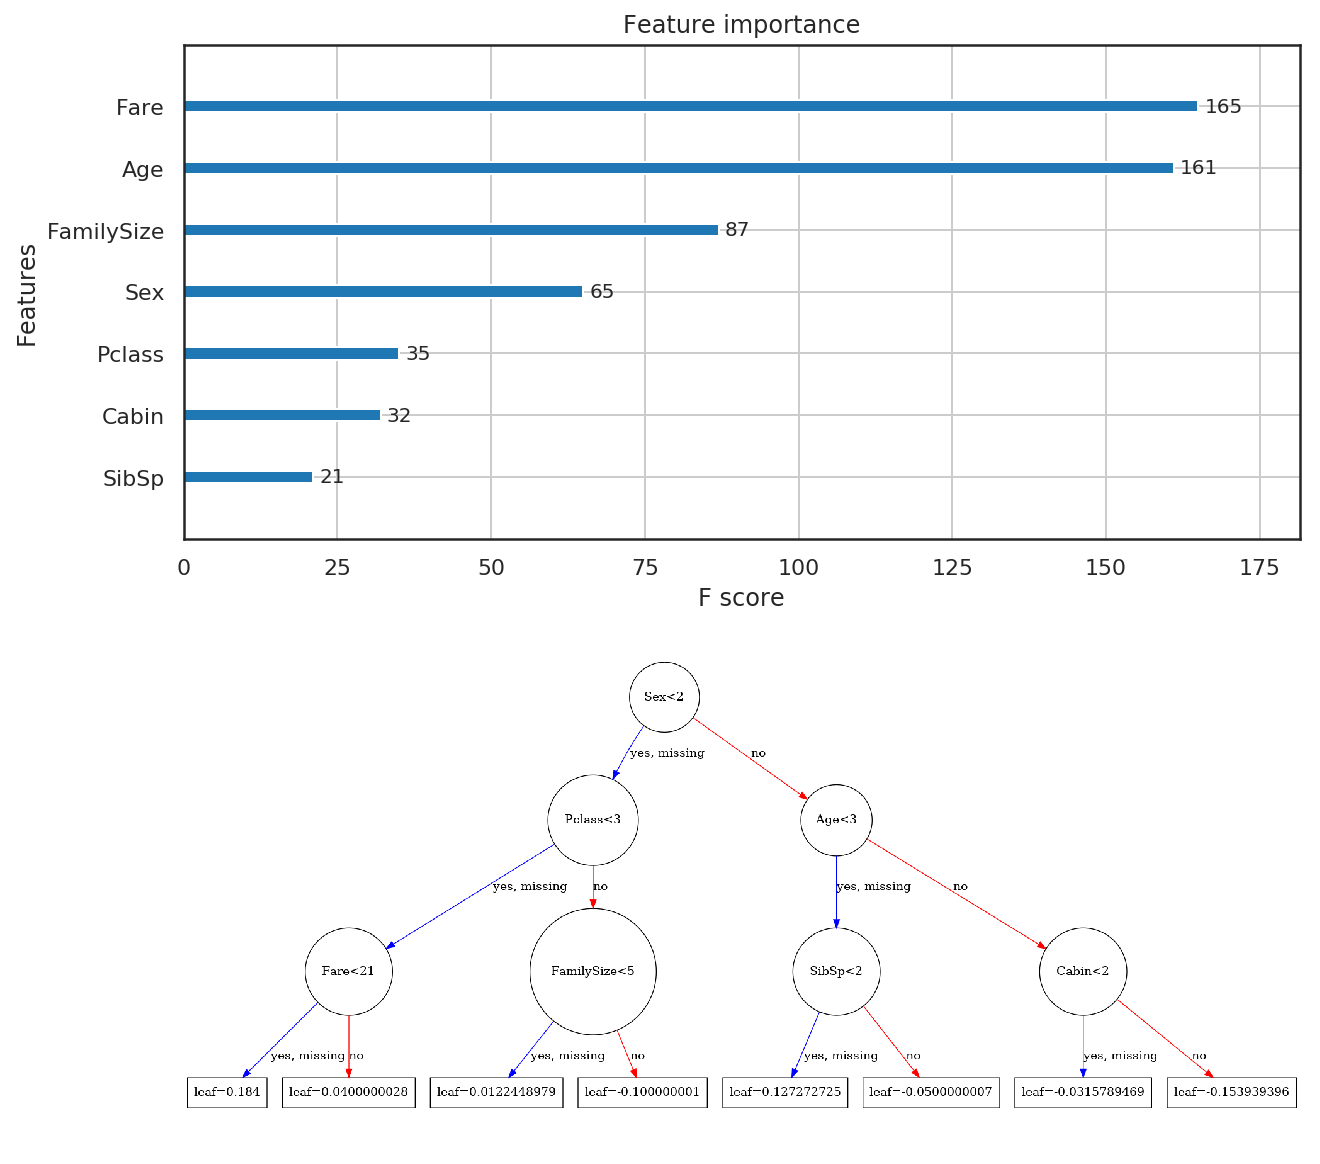

In [168]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

_=plot_importance(model, ax=axes[0])
_=plot_tree(model, ax=axes[1])

In [149]:
test_survived = pd.Series(model.predict(X_test_selected), name='Survived')

results = pd.concat([testdata['PassengerId'], test_survived], axis=1)

results.head(50)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [141]:
results.to_csv(os.getcwd()+'/../data/results/Final_Submission_XGBoost.csv', index=False)